In [1]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pickle

from matplotlib import rcParams
from scipy.optimize import curve_fit, root_scalar
from scipy.signal import savgol_filter


In [2]:
rcParams['figure.figsize'] = 12, 5
plt.rcParams.update({'font.size': 15})
plotsize = (10, 6)
legend_size = 12
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

# 1. Map out Hystersis

### 1.1 Generate Voltages

In [3]:
min_voltage = -4
max_voltage = 4
voltage_step = 0.5

# 3 is up, down, up
num_passes = 3

voltages = []

for i in range(num_passes):
    if i == 0:
        first_pass = np.arange(min_voltage, max_voltage + voltage_step, voltage_step)
        voltages.extend(first_pass)
    elif i % 2 == 0:
        one_pass = np.arange(min_voltage + voltage_step, max_voltage + voltage_step, voltage_step)
        voltages.extend(one_pass)
    elif i % 2 == 1:
        one_pass = np.arange(max_voltage - voltage_step, min_voltage - voltage_step, -voltage_step)
        voltages.extend(one_pass)

voltages = np.array(voltages)
print(voltages)

[-4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5
  3.   3.5  4.   3.5  3.   2.5  2.   1.5  1.   0.5  0.  -0.5 -1.  -1.5
 -2.  -2.5 -3.  -3.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5
  1.   1.5  2.   2.5  3.   3.5  4. ]


In [4]:
voltages[::-1]

array([ 4. ,  3.5,  3. ,  2.5,  2. ,  1.5,  1. ,  0.5,  0. , -0.5, -1. ,
       -1.5, -2. , -2.5, -3. , -3.5, -4. , -3.5, -3. , -2.5, -2. , -1.5,
       -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,
        3.5,  3. ,  2.5,  2. ,  1.5,  1. ,  0.5,  0. , -0.5, -1. , -1.5,
       -2. , -2.5, -3. , -3.5, -4. ])

### 1.2 Import Spec Data

In [5]:
def get_data(filename):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    voltage_vector = data1['voltage_vector']

    voltage_vector = np.asarray(voltage_vector[0])
    specFreqVector1 = np.asarray(specFreqVector1[0])*1e-9
    
    
    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    amp = amp#[::-1]
    Z = amp.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return voltage_vector, specFreqVector1, Z

In [6]:
def get_center_frequencies(voltages, frequencies, transmission_data, start_index=5, frequency_index_span=100, plot_fits=False):
    '''
    :param frequency_index_span: number of points around peak to try fit
    '''
    
#     center_frequencies = np.zeros(voltage_data.shape[1])
#     center_frequency_errors = np.zeros(voltage_data.shape[0])
    center_frequencies = []
    center_frequency_errors = []
    voltages_with_fit = []
    
    
    if isinstance(start_index, int):
        start_indices = [start_index] * transmission_data.shape[1]
    else:
        start_indices = list(start_index)
    
    for i in range(transmission_data.shape[1]):
        
#         print(f'index: {i}')
        
        # find peak
        if i >= len(start_indices):
            start_index = start_indices[-1]
        else:
            start_index = start_indices[i]
        row = transmission_data[start_index:,i]
        
        peak_index = np.argmax(row) + start_index
        center_frequency_guess = frequencies[peak_index]
        
        
        # fit to lorentzian
        # restrict fit in range span around peak

        restricted_frequencies = frequencies[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies))]
        restricted_row = transmission_data[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies)),i]
        
        # apply savgol filter
        
        filtered_row = savgol_filter(restricted_row, 7, 1)
        
        bounds = ([restricted_frequencies[0], 0, 0, -np.inf], [restricted_frequencies[-1], np.inf, np.inf, np.inf])
        initial_guess = [center_frequency_guess, 0.001, 0.0001, 0]
        try:
            popt, pcov = curve_fit(lorentzian_fit, restricted_frequencies, filtered_row, p0=initial_guess, bounds=bounds)
        except:
            # if it fails, plot the data it was trying to fit
            plt.plot(restricted_frequencies, filtered_row, linestyle='', marker='o', label='data')
            plt.plot(restricted_frequencies, lorentzian_fit(restricted_frequencies, *initial_guess), label='guess')
            plt.xlabel('Frequency (MHz)')
            plt.title(f'Lorentzian fit for index {i}')
            plt.axvline(center_frequency_guess, color='red', linestyle=':')
            plt.legend()
            plt.show()
            
            print('Couldn\'t get a fit')
            
            # use max as the center frequency
            center_frequencies.append(restricted_frequencies[np.argmax(filtered_row)])
            voltages_with_fit.append(voltages[i])
            center_frequency_errors.append(frequencies[-1] - frequencies[0])
            
            
        else:
            
            center_frequencies.append(popt[0])

            perr = np.sqrt(np.diag(pcov))
            center_frequency_errors.append(perr[0])

            voltages_with_fit.append(voltages[i])
            
            if plot_fits:
                plt.plot(frequencies[start_index:], row, linestyle='', marker='o', label='data')

                fit_frequencies = np.linspace(frequencies[start_index], frequencies[-1], 1000)
                plt.plot(fit_frequencies, lorentzian_fit(fit_frequencies, *popt), label='fit')
                plt.axvline(center_frequency_guess, color='red', linestyle=':')
                plt.legend()

                plt.xlabel('Frequency (MHz)')
                plt.title(f'Lorentzian fit for index {i}')
                plt.show()

                print(f'Center frequency is {popt[0]} MHz')
            
    return voltages_with_fit, center_frequencies, center_frequency_errors


In [7]:
def lorentzian_fit(x, x0, a, b, c):
    return a/(b+np.power((x-x0), 2))+c

In [8]:
def generate_filename(datecode, timecode):
    return r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax{}24\2Tone4Qubit_NR_2024{}_{}'.format(datecode, datecode, timecode)

In [9]:
# label files and data with qubit-coupler pairs

qubit_coupler_to_filename = {}
qubit_coupler_to_title = {}

In [10]:
print(generate_filename('0718', '2345'))

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071824\2Tone4Qubit_NR_20240718_2345


In [141]:
# default: fast ramp, -4 --> +4 --> -4 V
# slow: slow ramp
# reverse: +4 --> -4 --> +4
# C12 +1 flux: coupler C12 is moved to +1 flux from default
# +4 --> -2.5: +4 --> -2.5 --> +4 --> -4
# +4 --> -2: +4 --> -2 --> +4 --> -4
# +4 --> -4: +4 --> -4 --> +4 --> -4

# two ramp pos neg: ramp to +V then -V for each point, i.e. +4 then -4 then fixed value, then +3.5 then -3.5 then fixed value, etc.

### label data as a tuple of (readout qubit, fixed qubit/coupler, swept qubit/coupler)
# readout qubit: defines which resonator we readout to measure qubit frequency
# fixed qubit/coupler: one coupler is kept at its linear part so qubit frequency is sensitive to its shift in flux
# swept qubit/coupler: one qubit or coupler is ramped to different voltage values before being ramped back to its readout voltage in order
#   to map out hysteresis

### Q2

qubit_coupler_label = ('Q2', 'Q2', 'Q2')

qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0718', '1931')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q2 first voltage ramp, readout Q2'

### C12 fixed

# C12
qubit_coupler_label = ('Q2', 'C12', 'C12')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0718', '1448')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C12 first voltage ramp, readout Q2'

qubit_coupler_to_filename[qubit_coupler_label]['slow'] = generate_filename('0718', '2345')
qubit_coupler_to_title[qubit_coupler_label]['slow'] = 'Sweep C12 first voltage slow ramp, readout Q2'

qubit_coupler_to_filename[qubit_coupler_label]['C12 +1 flux'] = generate_filename('0719', '2033')
qubit_coupler_to_title[qubit_coupler_label]['C12 +1 flux'] = 'Sweep C12 first voltage ramp, readout Q2, C12 +1 flux'

# C13
qubit_coupler_label = ('Q2', 'C12', 'C13')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0718', '1703')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C13 first voltage ramp, readout Q2'

# C23
qubit_coupler_label = ('Q2', 'C12', 'C23')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0718', '1804')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C23 first voltage ramp, readout Q2'

qubit_coupler_to_filename[qubit_coupler_label]['reverse'] = generate_filename('0718', '2248')
qubit_coupler_to_title[qubit_coupler_label]['reverse'] = 'Sweep C23 first voltage ramp, readout Q2, +4 --> -4'

# C24
qubit_coupler_label = ('Q2', 'C12', 'C24')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0718', '1607')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C24 first voltage ramp, readout Q2'

qubit_coupler_to_filename[qubit_coupler_label]['reverse'] = generate_filename('0718', '2144')
qubit_coupler_to_title[qubit_coupler_label]['reverse'] = 'Sweep C24 first voltage ramp, readout Q2, +4 --> -4'

qubit_coupler_to_filename[qubit_coupler_label]['C12 +1 flux'] = generate_filename('0719', '1514')
qubit_coupler_to_title[qubit_coupler_label]['C12 +1 flux'] = 'Sweep C24 first voltage ramp, readout Q2, C12 +1 flux'

qubit_coupler_to_filename[qubit_coupler_label]['+4 --> -2.5 C12 +1 flux'] = generate_filename('0719', '1600')
qubit_coupler_to_title[qubit_coupler_label]['+4 --> -2.5 C12 +1 flux'] = 'Sweep C24 first voltage ramp, readout Q2, +4 --> -2.5, C12 +1 flux'

qubit_coupler_to_filename[qubit_coupler_label]['+4 --> -4 C12 +1 flux'] = generate_filename('0719', '1632')
qubit_coupler_to_title[qubit_coupler_label]['+4 --> -4 C12 +1 flux'] = 'Sweep C24 first voltage ramp, readout Q2, +4 --> -4, C12 +1 flux'

qubit_coupler_to_filename[qubit_coupler_label]['+4 --> -2 C12 +1 flux'] = generate_filename('0719', '1710')
qubit_coupler_to_title[qubit_coupler_label]['+4 --> -2 C12 +1 flux'] = 'Sweep C24 first voltage ramp, readout Q2, +4 --> -2, C12 +1 flux'


# C34
qubit_coupler_label = ('Q2', 'C12', 'C34')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}                                        
                                             
qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0719', '0936')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C34 first voltage ramp, readout Q2'


# sweep Q2
qubit_coupler_label = ('Q2', 'C12', 'Q2')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}                                        
                                             
qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '2051')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q2, first voltage ramp, fix C12, readout Q2'

# sweep Q3
qubit_coupler_label = ('Q2', 'C12', 'Q3')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}                                        
                                             
qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '2128')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q3, first voltage ramp, fix C12, readout Q2'

# sweep Q4
qubit_coupler_label = ('Q2', 'C12', 'Q4')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}                                        
                                             
qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '2152')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q4, first voltage ramp, fix C12, readout Q2'


### C23 fixed
# for these default is -4 --> +4 --> -4

# C24
qubit_coupler_label = ('Q2', 'C23', 'C24')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0722', '1023')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C24 first voltage ramp, fix C23, readout Q2'

# C23
qubit_coupler_label = ('Q2', 'C23', 'C23')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0722', '1102')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C23 first voltage ramp, fix C23, readout Q2'

# C34
qubit_coupler_label = ('Q2', 'C23', 'C34')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0722', '1127')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C34 first voltage ramp, fix C23, readout Q2'

# Q4
qubit_coupler_label = ('Q2', 'C23', 'Q4')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0722', '1158')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q4 first voltage ramp, fix C23, readout Q2'

In [165]:
# -4 --> 1.5: -4 --> +4 --> -4 --> 1.5 --> -2 --> 1.5

### Q3

### fix C34

# C12
qubit_coupler_label = ('Q3', 'C34', 'C12')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0720', '1503')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C12 first voltage ramp, readout Q3'

qubit_coupler_to_filename[qubit_coupler_label]['-4 --> 1.5'] = generate_filename('0722', '1550')
qubit_coupler_to_title[qubit_coupler_label]['-4 --> 1.5'] = 'Sweep C12 first voltage ramp, fix C34, readout Q3, -4 --> +4 --> -4 --> 1.5 --> -2 --> 1.5'

qubit_coupler_to_filename[qubit_coupler_label]['-4 --> 3'] = generate_filename('0722', '1725')
qubit_coupler_to_title[qubit_coupler_label]['-4 --> 3'] = 'Sweep C12 first voltage ramp, fix C34, readout Q3, -4 --> +4 --> -4 --> 1.5 --> -1 --> 3'

qubit_coupler_to_filename[qubit_coupler_label]['-4 --> 2 --> 3'] = generate_filename('0722', '1841')
qubit_coupler_to_title[qubit_coupler_label]['-4 --> 2 --> 3'] = 'Sweep C12 first voltage ramp, fix C34, readout Q3, -4 --> +4 --> -4 --> 2 --> -1 --> 3'


# C13
qubit_coupler_label = ('Q3', 'C34', 'C13')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0720', '1611')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C13 first voltage ramp, readout Q3'

# C23
qubit_coupler_label = ('Q3', 'C34', 'C23')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0720', '2021')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C23 first voltage ramp, readout Q3'

# C24
qubit_coupler_label = ('Q3', 'C34', 'C24')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0720', '2058')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C24 first voltage ramp, readout Q3'

qubit_coupler_to_filename[qubit_coupler_label]['two ramp pos neg'] = generate_filename('0721', '1118')
qubit_coupler_to_title[qubit_coupler_label]['two ramp pos neg'] = 'Sweep C24 first voltage ramp, readout Q3, two ramp pos neg'

qubit_coupler_to_filename[qubit_coupler_label]['C34 flux 2'] = generate_filename('0721', '1250')
qubit_coupler_to_title[qubit_coupler_label]['C34 flux 2'] = 'Sweep C24 first voltage ramp, readout Q3, C34 flux point 2'

qubit_coupler_to_filename[qubit_coupler_label]['C34 flux 3'] = generate_filename('0721', '1326')
qubit_coupler_to_title[qubit_coupler_label]['C34 flux 3'] = 'Sweep C24 first voltage ramp, readout Q3, C34 flux point 3'

# C34
qubit_coupler_label = ('Q3', 'C34', 'C34')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0720', '1350')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C34 first voltage ramp, readout Q3'

# sweep Q2
qubit_coupler_label = ('Q3', 'C34', 'Q2')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1031')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q2 first voltage ramp, fix C34, readout Q3'

# sweep Q3
qubit_coupler_label = ('Q3', 'C34', 'Q3')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1121')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q3 first voltage ramp, fix C34, readout Q3'

qubit_coupler_to_filename[qubit_coupler_label]['C34 flux 3'] = generate_filename('0722', '0823')
qubit_coupler_to_title[qubit_coupler_label]['C34 flux 3'] = 'Sweep Q3 first voltage ramp, fix C34, readout Q3, C34 flux point 3'



# sweep Q4
qubit_coupler_label = ('Q3', 'C34', 'Q4')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1054')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q4 first voltage ramp, fix C34, readout Q3'


### fix Q3

# sweep Q3
qubit_coupler_label = ('Q3', 'Q3', 'Q3')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0722', '1332')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q3 first voltage ramp, fix Q3, readout Q3'

qubit_coupler_to_filename[qubit_coupler_label]['default 2'] = generate_filename('0722', '1355')
qubit_coupler_to_title[qubit_coupler_label]['default 2'] = 'Sweep Q3 first voltage ramp, fix Q3, readout Q3, #2'


# sweep C34
qubit_coupler_label = ('Q3', 'Q3', 'C34')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0722', '1418')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C34 first voltage ramp, fix Q3, readout Q3'


In [191]:
### readout Q4

### fix C34

# C12
qubit_coupler_label = ('Q4', 'C34', 'C12')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0719', '1322')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C12 first voltage ramp, readout Q4'

# bad span
# qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0724', '2115')
# qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep C12 first voltage ramp, fix C34, readout Q4, flux point 2'

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0725', '0952')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep C12 first voltage ramp, fix C34, readout Q4, flux point 2'

# C13
qubit_coupler_label = ('Q4', 'C34', 'C13')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0720', '0136')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C13 first voltage ramp, readout Q4'

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0724', '1727')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep C13 first voltage ramp, fix C34, readout Q4, flux point 2'

# C23
qubit_coupler_label = ('Q4', 'C34', 'C23')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0720', '1123')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C23 first voltage ramp, readout Q4'

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0724', '1659')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep C23 first voltage ramp, fix C34, readout Q4, flux point 2'

# C24
qubit_coupler_label = ('Q4', 'C34', 'C24')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0719', '1219')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C24 first voltage ramp, readout Q4'

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0724', '2147')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep C24 first voltage ramp, fix C34, readout Q4, flux point 2'

# C34
qubit_coupler_label = ('Q4', 'C34', 'C34')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0719', '1127')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C34 first voltage ramp, readout Q4'

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0725', '0026')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep C34 first voltage ramp, fix C34, readout Q4, flux point 2'


# sweep Q2

qubit_coupler_label = ('Q4', 'C34', 'Q2')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0725', '1031')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep Q2 first voltage ramp, fix C34, readout Q4, flux point 2'

# sweep Q3

qubit_coupler_label = ('Q4', 'C34', 'Q3')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0724', '1928')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep Q3 first voltage ramp, fix C34, readout Q4, flux point 2'

# sweep Q4

qubit_coupler_label = ('Q4', 'C34', 'Q4')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0725', '1103')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep Q4 first voltage ramp, fix C34, readout Q4, flux point 2'

### fix C24

# sweep C12
qubit_coupler_label = ('Q4', 'C24', 'C12')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '1518')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C12 first voltage ramp, fix C24, readout Q4'

# sweep C13
qubit_coupler_label = ('Q4', 'C24', 'C13')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '1455')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C13 first voltage ramp, fix C24, readout Q4'

# sweep C23
qubit_coupler_label = ('Q4', 'C24', 'C23')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '1431')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C23 first voltage ramp, fix C24, readout Q4'

# sweep C34
qubit_coupler_label = ('Q4', 'C24', 'C34')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['-4 --> 3'] = generate_filename('0723', '1214')
qubit_coupler_to_title[qubit_coupler_label]['-4 --> 3'] = 'Sweep C34 first voltage ramp, fix C24, readout Q4, -4 --> +4 --> -4 --> 2.5 --> -1 --> 3'

qubit_coupler_to_filename[qubit_coupler_label]['C23 -3.5V'] = generate_filename('0723', '1333')
qubit_coupler_to_title[qubit_coupler_label]['C23 -3.5V'] = 'Sweep C34 first voltage ramp, fix C24, readout Q4, -4 --> +4 --> -4, C23 at -3.5V'

# sweep Q2
qubit_coupler_label = ('Q4', 'C24', 'Q2')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '1553')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q2 first voltage ramp, fix C24, readout Q4'

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0723', '1720')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep Q2 first voltage ramp, fix C24, readout Q4, flux point 2'

qubit_coupler_to_filename[qubit_coupler_label]['flux point 3'] = generate_filename('0723', '1744')
qubit_coupler_to_title[qubit_coupler_label]['flux point 3'] = 'Sweep Q2 first voltage ramp, fix C24, readout Q4, flux point 3'


# sweep Q3
qubit_coupler_label = ('Q4', 'C24', 'Q3')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '1620')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q3 first voltage ramp, fix C24, readout Q4'


# sweep Q4
qubit_coupler_label = ('Q4', 'C24', 'Q4')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0723', '1643')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q4 first voltage ramp, fix C24, readout Q4'

### fix Q4

# sweep Q4
qubit_coupler_label = ('Q4', 'Q4', 'Q4')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0722', '1448')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q4 first voltage ramp, fix Q4, readout Q4'

# sweep C34
qubit_coupler_label = ('Q4', 'Q4', 'C34')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0722', '1511')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C34 first voltage ramp, fix Q4, readout Q4'

# sweep Q2
qubit_coupler_label = ('Q4', 'Q4', 'Q2')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1213')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q2 first voltage ramp, fix Q4, readout Q4'

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1542')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q2 first voltage ramp, fix Q4, readout Q4, flux point 2'

# sweep Q3
qubit_coupler_label = ('Q4', 'Q4', 'Q3')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1241')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep Q3 first voltage ramp, fix Q4, readout Q4'

# sweep C12
qubit_coupler_label = ('Q4', 'Q4', 'C12')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1309')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C12 first voltage ramp, fix Q4, readout Q4'

# sweep C13
qubit_coupler_label = ('Q4', 'Q4', 'C13')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1333')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C13 first voltage ramp, fix Q4, readout Q4'

# sweep C23
qubit_coupler_label = ('Q4', 'Q4', 'C23')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1358')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C23 first voltage ramp, fix Q4, readout Q4'

# sweep C24
qubit_coupler_label = ('Q4', 'Q4', 'C24')
qubit_coupler_to_filename[qubit_coupler_label] = {}
qubit_coupler_to_title[qubit_coupler_label] = {}  

qubit_coupler_to_filename[qubit_coupler_label]['default'] = generate_filename('0724', '1425')
qubit_coupler_to_title[qubit_coupler_label]['default'] = 'Sweep C24 first voltage ramp, fix Q4, readout Q4'

qubit_coupler_to_filename[qubit_coupler_label]['flux point 2'] = generate_filename('0724', '1518')
qubit_coupler_to_title[qubit_coupler_label]['flux point 2'] = 'Sweep C24 first voltage ramp, fix Q4, readout Q4, flux point 2'

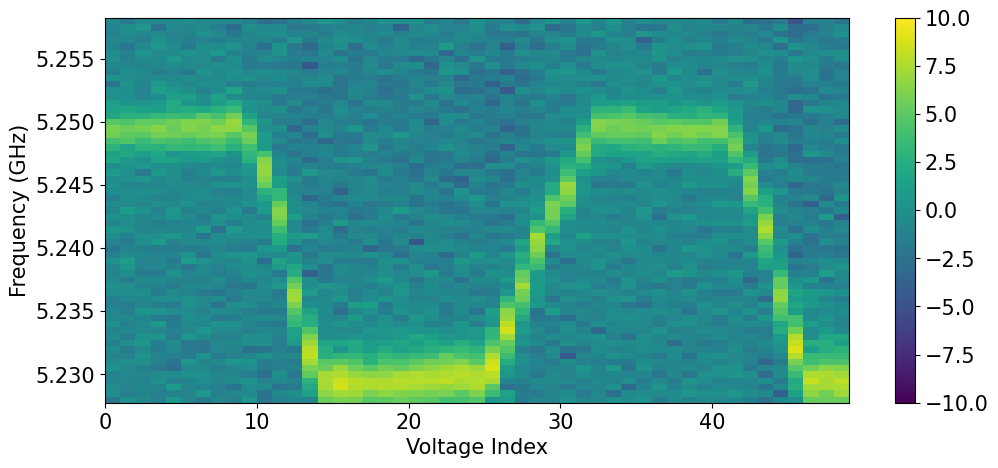

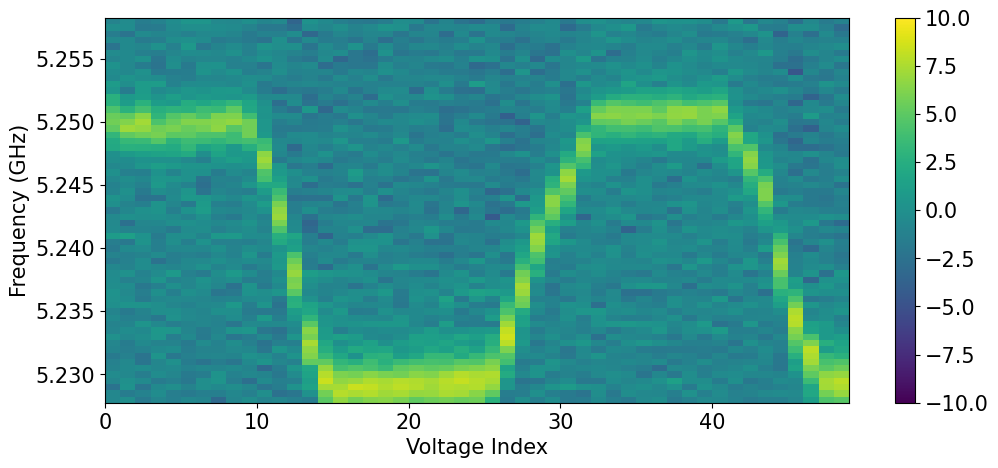

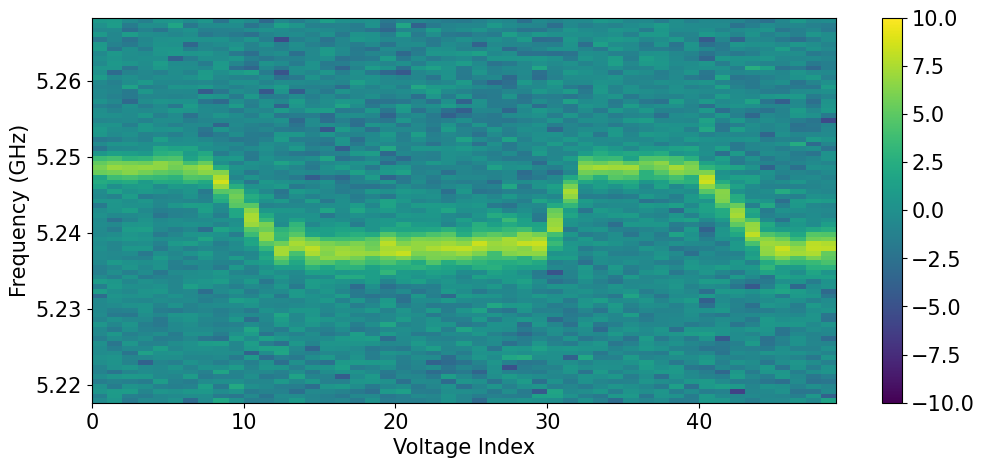

In [14]:
# plot transmission data

plot_readout_qubits = ['Q2', 'Q4']
plot_readout_qubits = ['Q4']
plot_readout_qubits = ['Q3']
plot_readout_qubits = ['Q2']

plot_fixed_qubits_and_couplers = ['C12', 'C34']
plot_fixed_qubits_and_couplers = ['C12']

plot_sweep_qubits_and_couplers = ['C12', 'C13', 'C23', 'C24', 'C34']
plot_sweep_qubits_and_couplers = ['C12']

# plot_qubit_couplers = [('Q2', None), ('Q2', 'C12'), ('Q2', 'C23'), ('Q2', 'C13'), ('Q2', 'C23'), ('Q2', 'C24'), ('Q2', 'C34')]

plot_qubit_couplers = product(plot_readout_qubits, plot_fixed_qubits_and_couplers, plot_sweep_qubits_and_couplers)

for qubit_coupler_label in plot_qubit_couplers:
    
    if qubit_coupler_label in qubit_coupler_to_filename:

        for filename in qubit_coupler_to_filename[qubit_coupler_label].values():

            voltage_vector, frequencies, transmission_data = get_data(filename)
            frequency_step = frequencies[1] - frequencies[0]
            voltage_step = voltage_vector[1] - voltage_vector[0]

            plt.imshow(transmission_data, vmin=-10, vmax=10, aspect='auto', interpolation='None', origin='lower', extent=(0, len(voltage_vector), frequencies[0] - frequency_step/2, frequencies[-1] + frequency_step/2))
            # plt.plot(indices_with_fit + 0.5, center_frequencies, marker='o', linestyle='', color='red')

            plt.colorbar()
            plt.xlabel('Voltage Index')
            plt.ylabel('Frequency (GHz)')

            plt.show()

### 1.3 Extract Peaks

In [15]:
def add_arrows(line, number_of_arrows=4, size=15, color=None):
    
    if color is None:
        color = line.get_color()
        
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    
    for i in range(number_of_arrows):
        start_index = int(i*(len(xdata)/number_of_arrows))
        
        if start_index < len(xdata) - 1:
            end_index = start_index + 1
        else:
            continue
    
        line.axes.annotate('',
            xytext=(xdata[start_index], ydata[start_index]),
            xy=(xdata[end_index], ydata[end_index]),
            arrowprops=dict(arrowstyle="->", color=color),
            size=size
        )

#### 1.3.1 Single File

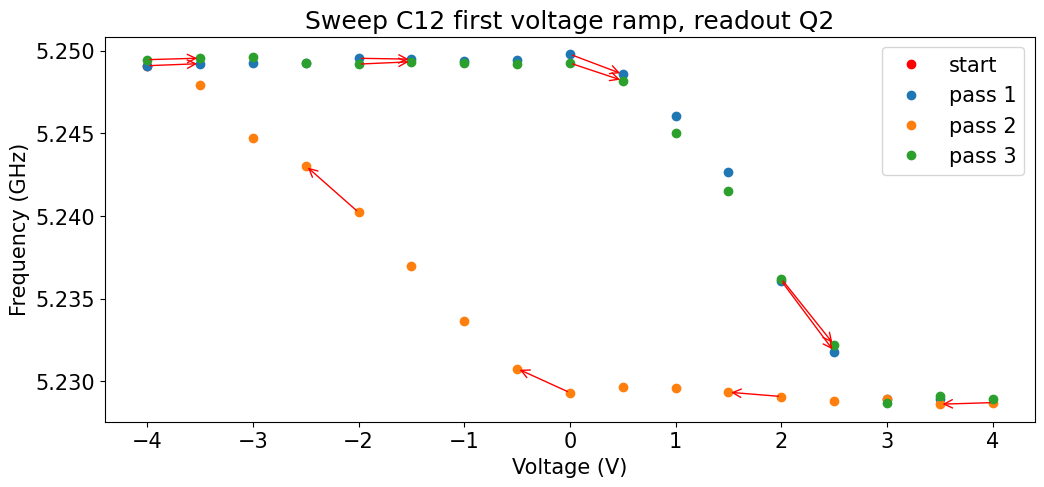

In [176]:
extract_readout_qubit = 'Q2'

extract_fixed_qubits_and_coupler = 'C12'

extract_sweep_qubits_and_coupler = 'C12'

file_label = '-4 --> 2.5 --> 3'
file_label = 'default'

# extract_qubit_couplers = [('Q2', None), ('Q2', 'C12'), ('Q2', 'C23'), ('Q2', 'C13'), ('Q2', 'C23'), ('Q2', 'C24'), ('Q2', 'C34')]

# if True, plot increasing and decreasing voltages with different colors. i.e. -4 --> +4, +4 --> -4, and -4 --> +4 all have different colors
plot_different_colors = True
num_passes = 3


plot_fits = False
start_index = 5
frequency_index_span = 50


filename = qubit_coupler_to_filename[(extract_readout_qubit, extract_fixed_qubits_and_coupler, extract_sweep_qubits_and_coupler)][file_label]

voltage_data, frequency_data, transmission_data = get_data(filename)


file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)

voltages = np.array(file_voltages)
frequencies = np.array(file_frequencies)


plt.plot(voltages[0], frequencies[0], marker='o', color='red', linestyle='', label='start')

if plot_different_colors:
    num_points = len(voltages)
    for i in range(num_passes):
        pass_start_index = (i*num_points)//num_passes
        pass_end_index = ((i+1)*num_points)//num_passes
        lines = plt.plot(voltages[pass_start_index:pass_end_index], frequencies[pass_start_index:pass_end_index], marker='o', linestyle='', label=f'pass {i+1}')
        add_arrows(lines[0], number_of_arrows=12//num_passes, color='red')
else:
    lines = plt.plot(voltages, frequencies, marker='o', linestyle='')
    add_arrows(lines[0], number_of_arrows=10, color='red')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')

title = qubit_coupler_to_title[(extract_readout_qubit, extract_fixed_qubits_and_coupler, extract_sweep_qubits_and_coupler)][file_label]
plt.title(title)

plt.legend()

plt.show()

#### 1.3.2 Multiple Files

In [17]:
qubit_coupler_to_voltages = {}
qubit_coupler_to_frequencies = {}

In [18]:
all_qubits_and_couplers = ['Q2', 'Q3', 'Q4', 'C12', 'C13', 'C23', 'C24', 'C34']

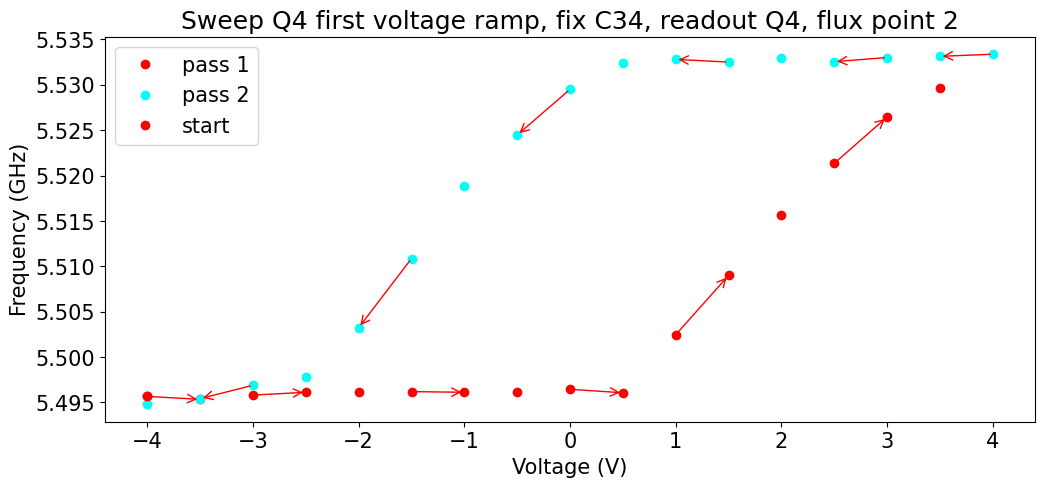

In [194]:
extract_readout_qubits = ['Q2', 'Q4']
# extract_readout_qubits = ['Q4']
# extract_readout_qubits = ['Q3']
extract_readout_qubits = ['Q3']
extract_readout_qubits = ['Q4']
# extract_readout_qubits = all_qubits_and_couplers

extract_fixed_qubits_and_couplers = ['C12', 'C34', 'Q2', 'C23']
# extract_fixed_qubits_and_couplers = ['C23']
extract_fixed_qubits_and_couplers = ['C12']
extract_fixed_qubits_and_couplers = ['C34']
# extract_fixed_qubits_and_couplers = ['Q4']
# extract_fixed_qubits_and_couplers = ['C24']
# extract_fixed_qubits_and_couplers = all_qubits_and_couplers

extract_sweep_qubits_and_couplers = ['C12', 'C13', 'C23', 'C24', 'C34', 'Q2', 'Q3', 'Q4']
# extract_sweep_qubits_and_couplers = ['C24', 'C34', 'Q3']
# extract_sweep_qubits_and_couplers = ['Q4', 'C34']
# extract_sweep_qubits_and_couplers = ['C12']
extract_sweep_qubits_and_couplers = ['Q4']
# extract_sweep_qubits_and_couplers = ['C34', 'C12', 'C13', 'C23', 'C24']
# extract_sweep_qubits_and_couplers = all_qubits_and_couplers

# extract_qubit_couplers = [('Q2', None), ('Q2', 'C12'), ('Q2', 'C23'), ('Q2', 'C13'), ('Q2', 'C23'), ('Q2', 'C24'), ('Q2', 'C34')]

extract_qubit_couplers = product(extract_readout_qubits, extract_fixed_qubits_and_couplers, extract_sweep_qubits_and_couplers)

# if True, plot increasing and decreasing voltages with different colors. i.e. -4 --> +4, +4 --> -4, and -4 --> +4 all have different colors
plot_different_colors = True
num_passes = 4

plot_fits = False

color_type = 'simple' # sets a different color for each of `num_passes` equally sized segments
color_type = 'smart' # automatically determines when the x data switches from increasing to decreasing and switches color at this point


for qubit_coupler_label in extract_qubit_couplers:
    if qubit_coupler_label in qubit_coupler_to_filename:

        qubit_coupler_voltages = {}
        qubit_coupler_frequencies = {}

        voltages = []
        frequencies = []

        start_index = 5
        frequency_index_span = 50
        
        for label, filename in qubit_coupler_to_filename[qubit_coupler_label].items():
            

            voltage_data, frequency_data, transmission_data = get_data(filename)
            file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index=start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)
            plt.show()

            voltages = np.array(file_voltages)
            frequencies = np.array(file_frequencies)

            qubit_coupler_voltages[label] = voltages
            qubit_coupler_frequencies[label] = frequencies

            
            if plot_different_colors:
                if color_type == 'simple':
                    num_points = len(voltages)
                    for i in range(num_passes):
                        pass_start_index = (i*num_points)//num_passes
                        pass_end_index = ((i+1)*num_points)//num_passes
                        lines = plt.plot(voltages[pass_start_index:pass_end_index], frequencies[pass_start_index:pass_end_index], marker='o', linestyle='', label=f'pass {i+1}')
                        add_arrows(lines[0], number_of_arrows=12//num_passes, color='red')
                elif color_type == 'smart':
                    # Calculate the differences between consecutive x values
                    voltage_diffs = np.diff(voltages)
                    
                    # Find the indices where the sign of the difference changes
                    change_indices = np.where(np.diff(np.sign(voltage_diffs)) != 0)[0] + 1
                    
                    # Include the start and end indices
                    segments = np.split(np.arange(len(voltages)), change_indices)
                    
                    # Plot each segment with a different color
                    colors = plt.cm.hsv(np.linspace(0, 1, len(segments)+1))
                    
                    for i in range(len(segments)):
                        segment = segments[i]
                        color = colors[i]
                        lines = plt.plot(voltages[segment], frequencies[segment], color=color, marker='o',linestyle='', label=f'pass {i+1}')
                        add_arrows(lines[0], number_of_arrows=12//len(segments), color='red')
                    
            else:
                lines = plt.plot(voltages, frequencies, marker='o', linestyle='')
                add_arrows(lines[0], number_of_arrows=10, color='red')
                
            plt.plot(voltages[0], frequencies[0], marker='o', color='red', linestyle='', label='start')

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            title = qubit_coupler_to_title[qubit_coupler_label][label]
            plt.title(title)

            plt.legend()

            plt.show()

        qubit_coupler_to_voltages[qubit_coupler_label] = qubit_coupler_voltages
        qubit_coupler_to_frequencies[qubit_coupler_label] = qubit_coupler_frequencies


In [20]:
print(qubit_coupler_to_filename[('Q2', 'C12', 'C24')])


{'default': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax071824\\2Tone4Qubit_NR_20240718_1607', 'reverse': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax071824\\2Tone4Qubit_NR_20240718_2144', 'C12 +1 flux': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax071924\\2Tone4Qubit_NR_20240719_1514', '+4 --> -2.5 C12 +1 flux': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax071924\\2Tone4Qubit_NR_20240719_1600', '+4 --> -4 C12 +1 flux': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax071924\\2Tone4Qubit_NR_20240719_1632', '+4 --> -2 C12 +1 flux': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax071924\\2Tone4Qubit_NR_20240719_1710'}


In [21]:
print(qubit_coupler_to_filename[('Q3', 'C34', 'C24')])
qubit_coupler_to_filename[('Q3', 'C34', 'C24')]

{'default': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax072024\\2Tone4Qubit_NR_20240720_2058', 'two ramp pos neg': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax072124\\2Tone4Qubit_NR_20240721_1118', 'C34 flux 2': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax072124\\2Tone4Qubit_NR_20240721_1250', 'C34 flux 3': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax072124\\2Tone4Qubit_NR_20240721_1326'}


{'default': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax072024\\2Tone4Qubit_NR_20240720_2058',
 'two ramp pos neg': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax072124\\2Tone4Qubit_NR_20240721_1118',
 'C34 flux 2': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax072124\\2Tone4Qubit_NR_20240721_1250',
 'C34 flux 3': 'V:\\QSimMeasurements\\Measurements\\4Q_Triangle_Lattice\\pnax072124\\2Tone4Qubit_NR_20240721_1326'}

In [157]:
def plot_multiple(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers, skip_labels=[], include_labels=None, align_frequencies=False, ylim=None, legend_fontsize=10):
    
    qubit_coupler_labels = product(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers)
    
    index = 0
    
    for qubit_coupler_label in qubit_coupler_labels:
        
        
        if not qubit_coupler_label in qubit_coupler_to_voltages:
            continue
            
        print(qubit_coupler_label)
            
        # skip labels and include labels can be provided as list or dict
        # if dict, the entry corresponding to qubit_coupler_label is the list
        if isinstance(include_labels, (list, tuple)):
            _include_labels = include_labels
        elif isinstance(include_labels, dict):
            _include_labels = include_labels[qubit_coupler_label]
            
        if isinstance(skip_labels, (list, tuple)):
            _skip_labels = skip_labels
        elif isinstance(skip_labels, dict):
            _skip_labels = skip_labels[qubit_coupler_label]
        
        for label in qubit_coupler_to_voltages[qubit_coupler_label]:
            # prioritize include labels over skip labels
            if not _include_labels is None:
                if not label in _include_labels:
                    continue
            else:
                if label in _skip_labels:
                    continue
            
            voltages = qubit_coupler_to_voltages[qubit_coupler_label][label]
            frequencies = qubit_coupler_to_frequencies[qubit_coupler_label][label]
            
            
            title = qubit_coupler_to_title[qubit_coupler_label][label]
            
            
                
            
            if align_frequencies:
                # offset all frequencies so that the first frequencies match each other bewteen each data set
                if index == 0:
                    first_frequency = frequencies[0]
                lines = plt.plot(voltages, frequencies + first_frequency - frequencies[0], marker='o', linestyle='', label=f'(offset): {title}')
                plt.plot(voltages[0], first_frequency, marker='o', color='red', linestyle='', label='start')
            else:
                lines = plt.plot(voltages, frequencies, marker='o', linestyle='', label=title)
            
                plt.plot(voltages[0], frequencies[0] , marker='o', color='red', linestyle='', label='start')
#             if index == 0:
#                 plt.plot(voltages[0], frequencies[0], marker='o', color='red', linestyle='', label='start')
#             else:
#                 if not align_frequencies:
#                     plt.plot(voltages[0], frequencies[0], marker='o', color='red', linestyle='')
           
            
                

            add_arrows(lines[0], number_of_arrows=10, color='red')

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.title(f'Readout {qubit_coupler_label[0]}, fix {qubit_coupler_label[1]}, sweep {qubit_coupler_label[2]}')

            # don't include duplicate labels
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), fontsize=legend_fontsize, loc='lower left')
            
            if ylim is not None:
                plt.ylim(*ylim)
                
            index += 1

    plt.show()
    

remaining file labels:
	default
	two ramp pos neg
	C34 flux 2
	C34 flux 3
	default
('Q3', 'C34', 'C24')
('Q4', 'C34', 'C24')


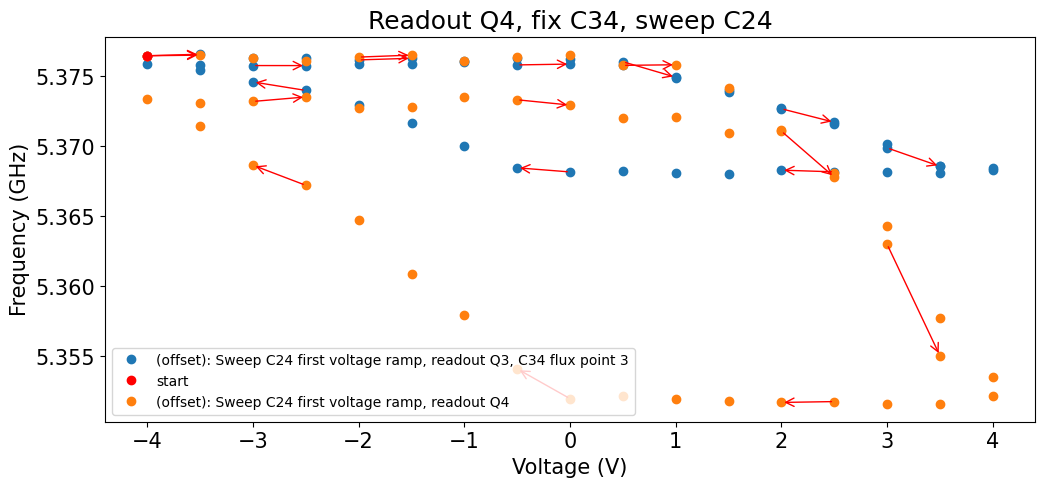

In [159]:
readout_qubits = ['Q2', 'Q4']
readout_qubits = ['Q4']
readout_qubits = ['Q2']
readout_qubits = all_qubits_and_couplers

fixed_qubits_and_couplers = ['C12', 'C34', 'Q2', 'C23']
fixed_qubits_and_couplers = ['C12']
fixed_qubits_and_couplers = ['C34']

sweep_qubits_and_couplers = ['C12', 'C13', 'C23', 'C24', 'C34', 'Q2', 'Q3', 'Q4']
sweep_qubits_and_couplers = ['C24']
# sweep_qubits_and_couplers = ['C12']

extract_qubit_couplers = product(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers)

skip_labels = []
# skip_labels = ['default', 'reverse', 'C12 +1 flux', '+4 --> -2.5 C12 +1 flux', '+4 --> -4 C12 +1 flux', '+4 --> -2 C12 +1 flux']

include_labels = None
include_labels = ['default', 'C34 flux 2', 'C34 flux 3']

include_labels = {('Q3', 'C34', 'C24'): ['C34 flux 3'],
                  ('Q4', 'C34', 'C24'): ['default']}


print('remaining file labels:')
for qubit_coupler_label in product(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers):
    if not qubit_coupler_label in qubit_coupler_to_filename:
        continue
    for file_label, filename in qubit_coupler_to_filename[qubit_coupler_label].items():
        if not file_label in skip_labels:
            print(f'\t{file_label}')

ylim = None
# ylim = (5.220, 5.255)
# ylim = (5.490, 5.540)

align_frequencies = True

plot_multiple(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers, skip_labels=skip_labels, 
              include_labels=include_labels, align_frequencies=align_frequencies, ylim=ylim)

# 2. Fit Hysteresis Data

### 2.1 Fit each pass to lines

In [24]:
def two_lines(x, *args):
    
    x0 = args[0] # point at which sloped line turns to flat line
    a = args[1] # x-coefficient, determines if fit is flipped in x direction
    b = args[2] # overall coefficient, determines slope and if fit is flipped in y direction
    c = args[3] # y offset
    
    if isinstance(x, (int, float)):
        if a*x < x0:
            # sloped line
            return b*(a*x - x0) + c
        else:
            # flat line
            return c
    elif isinstance(x, (list, np.ndarray)):
        y = np.zeros(x.shape)
        for i in range(len(x)):
            x_i = x[i]
            if a*x_i < x0:
                # sloped line
                y[i] = b*(a*x_i - x0) + c
            else:
                # flat line
                y[i] = c
        return y

In [25]:
def three_lines(x, *args):
    '''
    Fit to flat line, sloped line, flat line
    '''
    
    x0 = args[0] # point at which sloped line turns to flat line
    x1 = args[1]
    b = args[2] # overall coefficient, determines slope and if fit is flipped in y direction
    c = args[3] # y offset
    
    if isinstance(x, (int, float)):
        if x < x0:
            # flat line 1
            return c
        elif x0 <= x < x1:
            # sloped line
            return b*(x - x0) + c
        else:
            # flat line 2
            return b*(x1 - x0) + c
        
    elif isinstance(x, (list, np.ndarray)):
        y = np.zeros(x.shape)
        for i in range(len(x)):
            x_i = x[i]
            if x_i < x0:
            # flat line 1
                y[i] = c
            elif x0 <= x_i < x1:
                # sloped line
                y[i] = b*(x_i - x0) + c
            else:
                # flat line 2
                y[i] = b*(x1 - x0) + c
        return y

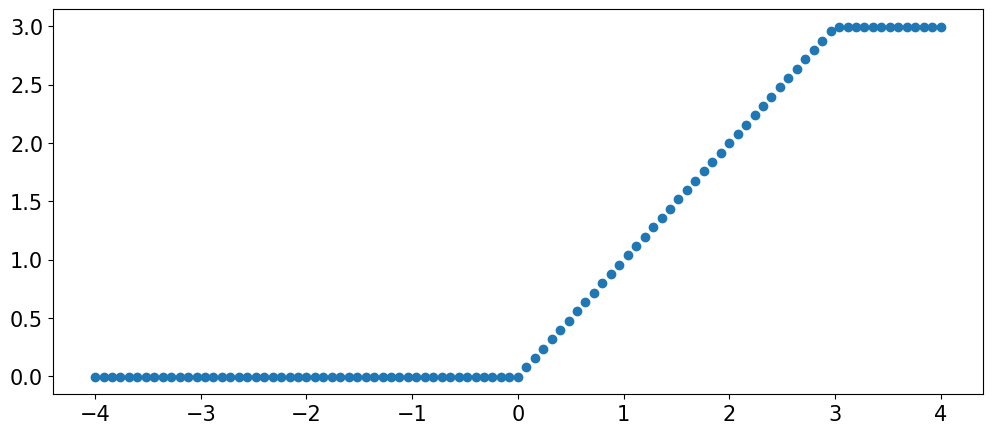

In [26]:
args = (0, 3, 1, -0.005, 5.23)

fit_voltages = np.linspace(-4, 4, 101)

y = three_lines(fit_voltages, *args)

plt.plot(fit_voltages, y, marker='o', linestyle='')

In [27]:
def get_hysteresis_fit(qubit_coupler_label, file_label, plot_fits=False):
    
    voltages = qubit_coupler_to_voltages[qubit_coupler_label][file_label]
    frequencies = qubit_coupler_to_frequencies[qubit_coupler_label][file_label]
    
    # split data into segments determined by if voltage is increasing or decreasing
    
    # Calculate the differences between consecutive x values
    voltage_diffs = np.diff(voltages)

    # Find the indices where the sign of the difference changes
    change_indices = np.where(np.diff(np.sign(voltage_diffs)) != 0)[0] + 1

    # Include the start and end indices
    segments = np.split(np.arange(len(voltages)), change_indices)

    # Plot each segment with a different color
    colors = plt.cm.hsv(np.linspace(0, 1, len(segments)+1))
    
    # one for each segment
    popts = []

    for i in range(len(segments)):
        segment = segments[i]
        segment_voltages = voltages[segment]
        segment_frequencies = frequencies[segment]
        
        # determine initial guess
        initial_guess_multiplier = -np.sign(voltage_diffs[segment[0]])
        
        if initial_guess_multiplier > 0:
            x0_guess = -4
            x1_guess = 0
        else:
            x0_guess = 0
            x1_guess = 4
            
        c_guess = np.max(segment_frequencies)
        

        min_freq_index = np.argmax(-segment_frequencies)
        max_freq_index = np.argmax(segment_frequencies)
        
        # twice the average slope
        b_guess = -2*(segment_frequencies[max_freq_index] - segment_frequencies[min_freq_index])/(segment_voltages[min_freq_index] - segment_voltages[max_freq_index])
        
        initial_guess = (0, 3, initial_guess_multiplier*0.005, 5.23)
#         initial_guess = (x0_guess, x1_guess, -0.05, c_guess)
#         initial_guess = (x0_guess, x1_guess, b_guess, c_guess)
#         initial_guess = (x0_guess, x1_guess, -initial_guess_multiplier*0.005, 5.38)


        bounds = ((-4, -4, -10, 0), (4, 4, 10, 10))
    
#         print(f'initial guess: {initial_guess}')
        
        fit_voltages = np.linspace(np.min(segment_voltages), np.max(segment_voltages), 101)
        
        try:
            popt, pcov = curve_fit(three_lines, segment_voltages, segment_frequencies, p0=initial_guess, bounds=bounds)
        except:
            print('couldn\'t find fit')
            
            plt.plot(segment_voltages, segment_frequencies, marker='o', linestyle='', label=f'segment {i+1} data')
            plt.plot(fit_voltages, three_lines(fit_voltages, *initial_guess), label=f'segment {i+1} guess')
            
            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.title(f'Hysteresis fit guess, sweep {qubit_coupler_label[2]}, fix {qubit_coupler_label[1]}, readout {qubit_coupler_label[0]}')

            plt.legend()
            plt.show()
            
            popts.append([])
            
        else:
            
            if plot_fits:
                plt.plot(segment_voltages, segment_frequencies, marker='o', linestyle='', label=f'segment {i+1} data')
                plt.plot(fit_voltages, three_lines(fit_voltages, *popt), label=f'segment {i+1} fit')
            
#             print(f'popt: {popt}\n')
            popts.append(popt)
        
    if plot_fits:
        plt.xlabel('Voltage (V)')
        plt.ylabel('Frequency (GHz)')

        plt.title(f'Hysteresis fit, sweep {qubit_coupler_label[2]}, fix {qubit_coupler_label[1]}, readout {qubit_coupler_label[0]}')

        plt.legend()
        plt.show()
        
    return popts
        
        
        

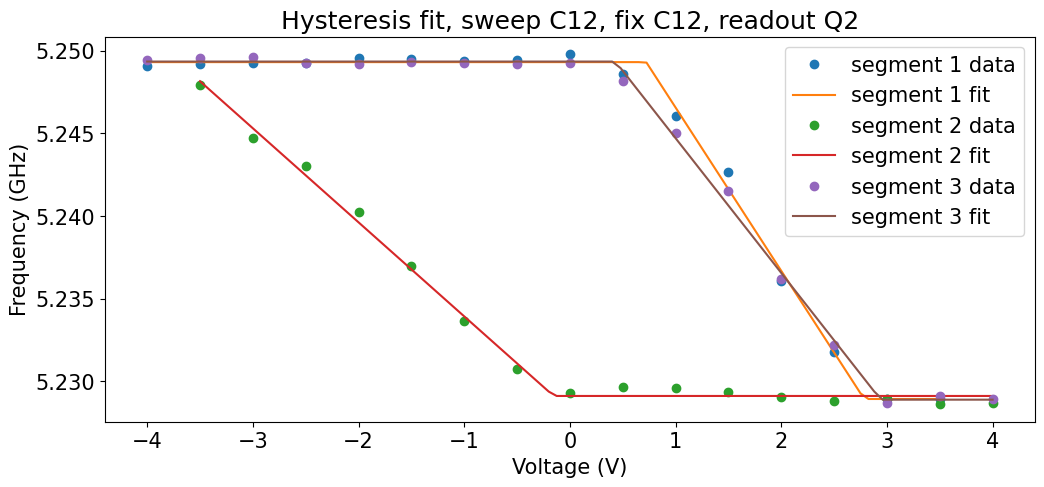

In [28]:
qubit_coupler_label = ('Q3', 'C34', 'C24')
qubit_coupler_label = ('Q2', 'C12', 'C23')
qubit_coupler_label = ('Q2', 'C12', 'C12')
file_label = 'default'
# file_label = 'C34 flux 3'
# file_label = 'C12 +1 flux'

plot_fits = True

popts = get_hysteresis_fit(qubit_coupler_label, file_label, plot_fits=plot_fits)

In [29]:
qubit_coupler_to_fit = {}

('Q4', 'C24', 'Q2')
	default


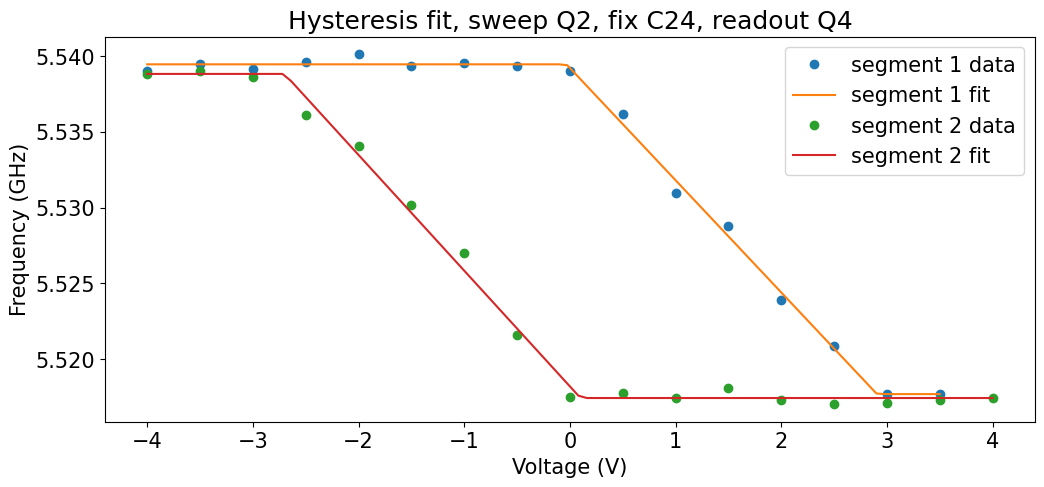

('Q4', 'C24', 'Q3')
	default


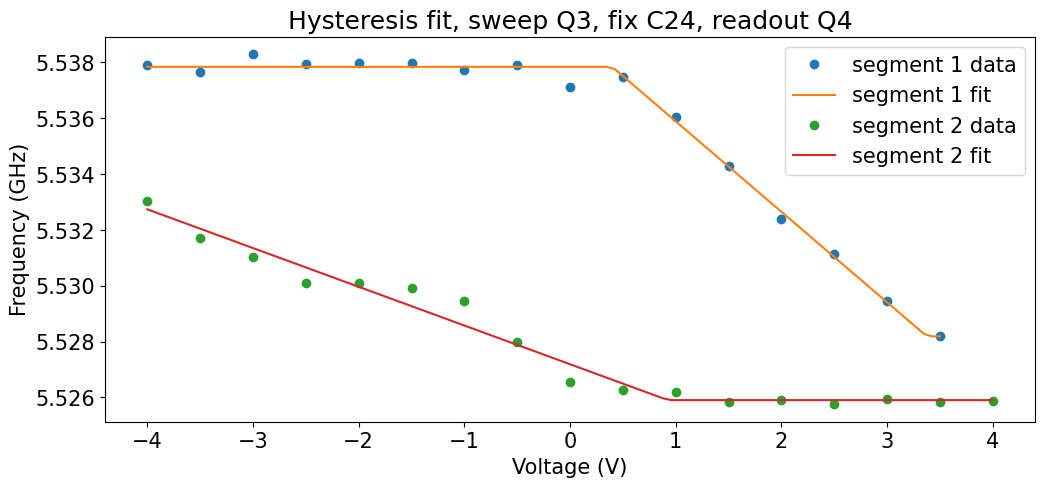

('Q4', 'C24', 'Q4')
	default


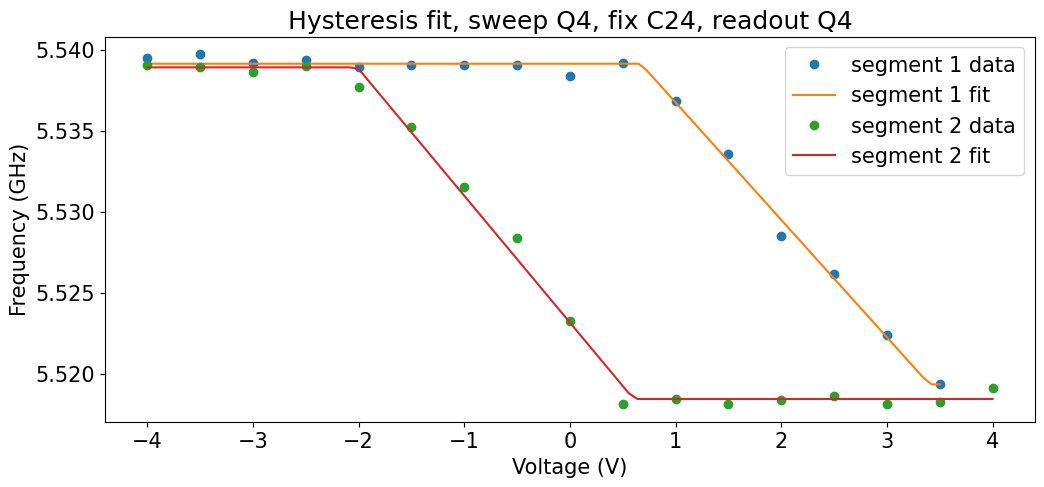

('Q4', 'C24', 'C12')
	default


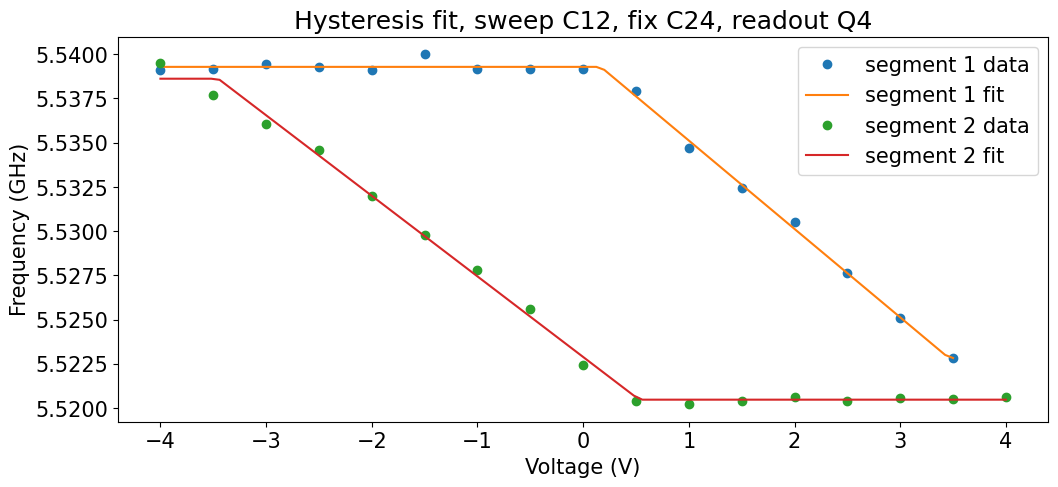

('Q4', 'C24', 'C13')
	default


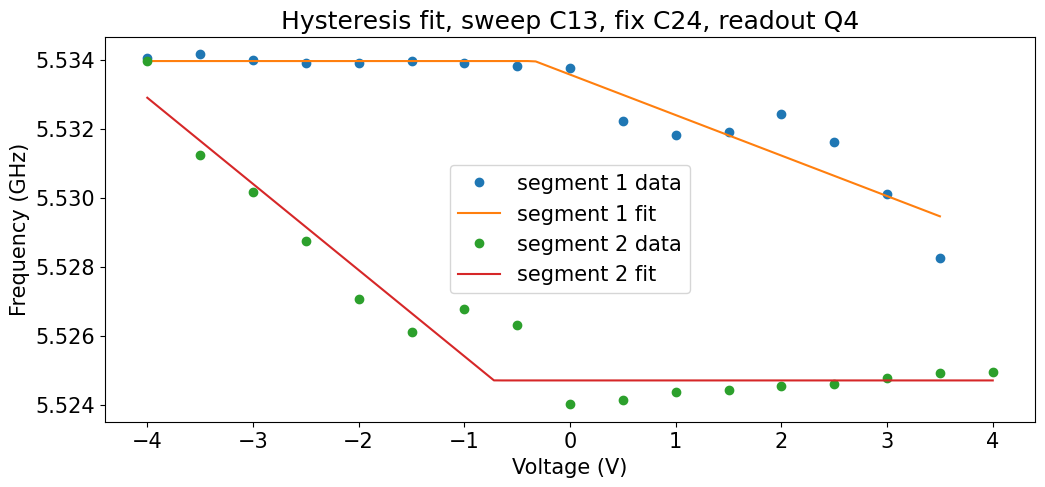

('Q4', 'C24', 'C23')
	default


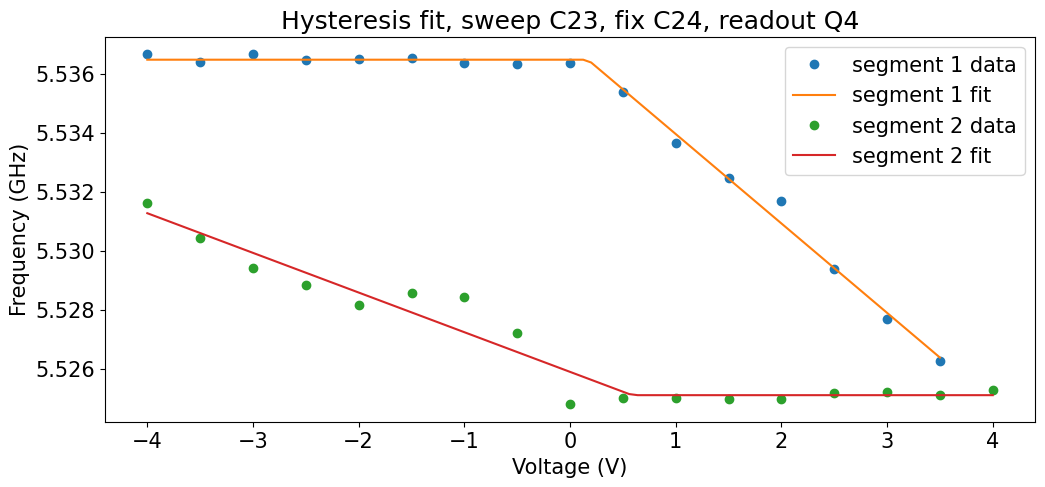

('Q4', 'C24', 'C34')
	-4 --> 3


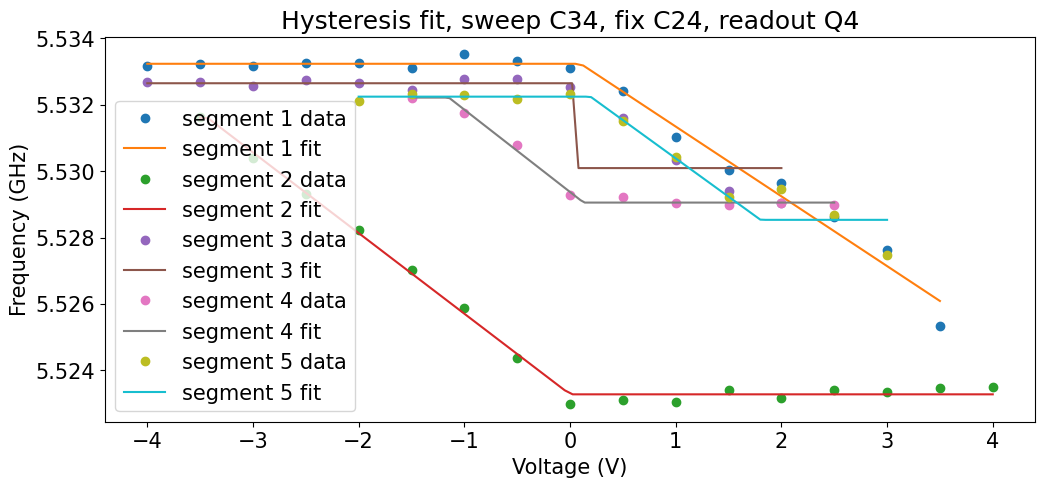

	C23 -3.5V


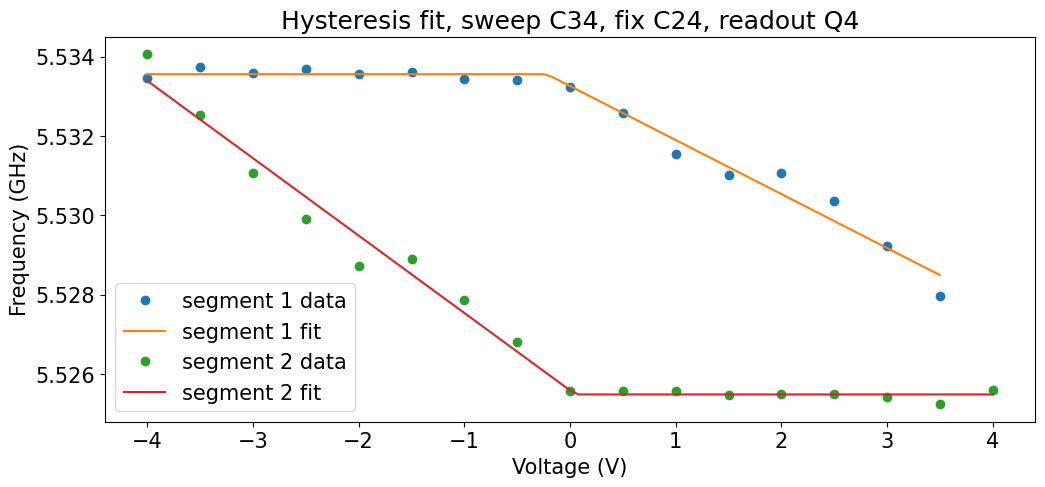

In [133]:
### get fits for multiple files

fit_readout_qubits = ['Q2', 'Q4']
fit_readout_qubits = ['Q4']
fit_readout_qubits = ['Q2']
fit_readout_qubits = ['Q4']
# fit_readout_qubits = all_qubits_and_couplers

fit_fixed_qubits_and_couplers = ['C12', 'C34', 'Q2', 'C23']
fit_fixed_qubits_and_couplers = ['C12']
fit_fixed_qubits_and_couplers = ['C24']
# fit_fixed_qubits_and_couplers = all_qubits_and_couplers

fit_sweep_qubits_and_couplers = ['C12', 'C13', 'C23', 'C24', 'C34', 'Q2', 'Q3', 'Q4']
fit_sweep_qubits_and_couplers = ['C24']
fit_sweep_qubits_and_couplers = ['C12']
fit_sweep_qubits_and_couplers = all_qubits_and_couplers

fit_qubit_couplers = product(fit_readout_qubits, fit_fixed_qubits_and_couplers, fit_sweep_qubits_and_couplers)

plot_fits = True

for qubit_coupler_label in fit_qubit_couplers:
    
    if not qubit_coupler_label in qubit_coupler_to_fit:
        qubit_coupler_to_fit[qubit_coupler_label] = {}
        
    if not qubit_coupler_label in qubit_coupler_to_voltages or not qubit_coupler_label in qubit_coupler_to_frequencies:
        continue
        
    qubit_coupler_voltages = qubit_coupler_to_voltages[qubit_coupler_label]
    qubit_coupler_frequencies = qubit_coupler_to_frequencies[qubit_coupler_label]
    
    print(qubit_coupler_label)
    
    for file_label in qubit_coupler_voltages:
        
        print(f'\t{file_label}')
        
        popt = get_hysteresis_fit(qubit_coupler_label, file_label, plot_fits=plot_fits)
        
        qubit_coupler_to_fit[qubit_coupler_label][file_label] = popt

        

In [134]:
qubit_coupler_to_bad_fits = {}

qubit_coupler_to_bad_fits[('Q2', 'Q2', 'Q2')] = {'default'}
qubit_coupler_to_bad_fits[('Q2', 'C23', 'C23')] = {'default'}
qubit_coupler_to_bad_fits[('Q2', 'C23', 'C24')] = {'default'}
qubit_coupler_to_bad_fits[('Q2', 'C23', 'C34')] = {'default'}
qubit_coupler_to_bad_fits[('Q3', 'Q3', 'Q3')] = {'default', 'default 2'}
qubit_coupler_to_bad_fits[('Q3', 'Q3', 'C34')] = {'default'}
qubit_coupler_to_bad_fits[('Q3', 'C34', 'C24')] = {'two ramp pos neg'}
qubit_coupler_to_bad_fits[('Q4', 'C24', 'C23')] = {'default'}
qubit_coupler_to_bad_fits[('Q4', 'C24', 'C13')] = {'default'}


### 2.2 Correlation to find gap width (scrap this)

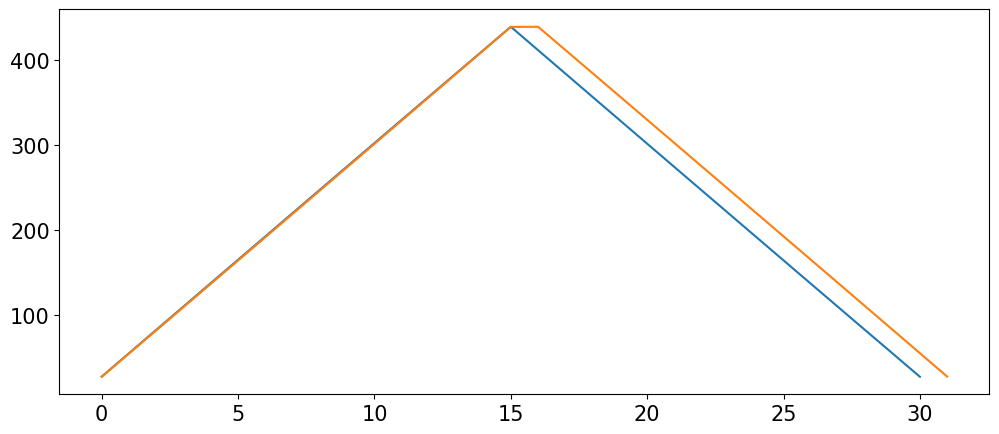

In [32]:
# qubit_coupler_label = ('Q3', 'C34', 'C24')
# qubit_coupler_label = ('Q2', 'C12', 'C23')
qubit_coupler_label = ('Q2', 'C12', 'C12')
file_label = 'default'



voltages = qubit_coupler_to_voltages[qubit_coupler_label][file_label]
frequencies = qubit_coupler_to_frequencies[qubit_coupler_label][file_label]

# split data into segments determined by if voltage is increasing or decreasing

# Calculate the differences between consecutive x values
voltage_diffs = np.diff(voltages)

# Find the indices where the sign of the difference changes
change_indices = np.where(np.diff(np.sign(voltage_diffs)) != 0)[0] + 1

# Include the start and end indices
segments = np.split(np.arange(len(voltages)), change_indices)

# Plot each segment with a different color
colors = plt.cm.hsv(np.linspace(0, 1, len(segments)+1))

segment_voltages = []
segment_frequencies = []

for i in range(len(segments)):
    segment = segments[i]
    segment_voltages.append(voltages[segment])
    segment_frequencies.append(frequencies[segment])
    
    
for i in range(len(segment_frequencies)-1):
    
    correlation = np.correlate(segment_frequencies[i], segment_frequencies[i+1], mode='full')


    plt.plot(correlation)

    
plt.show()




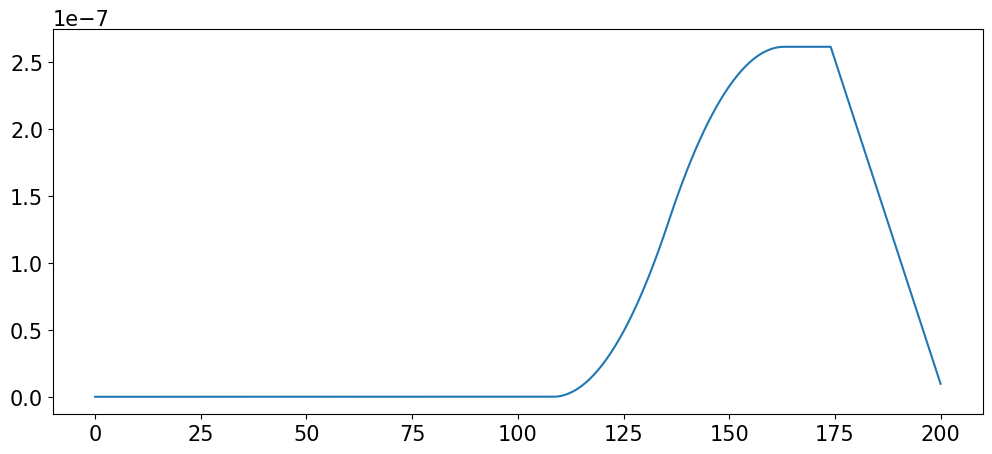

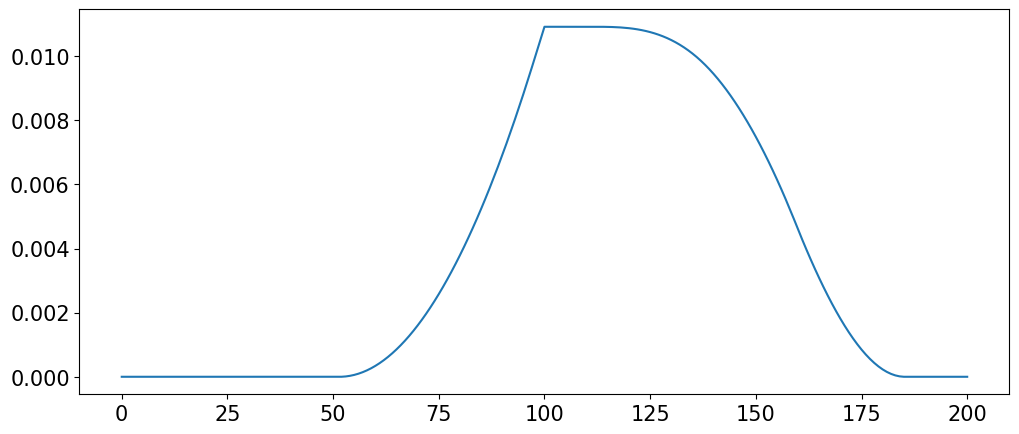

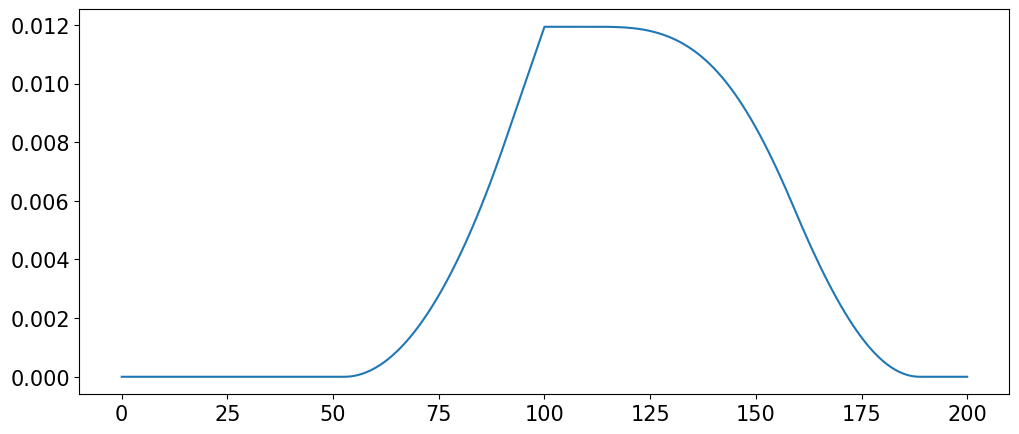

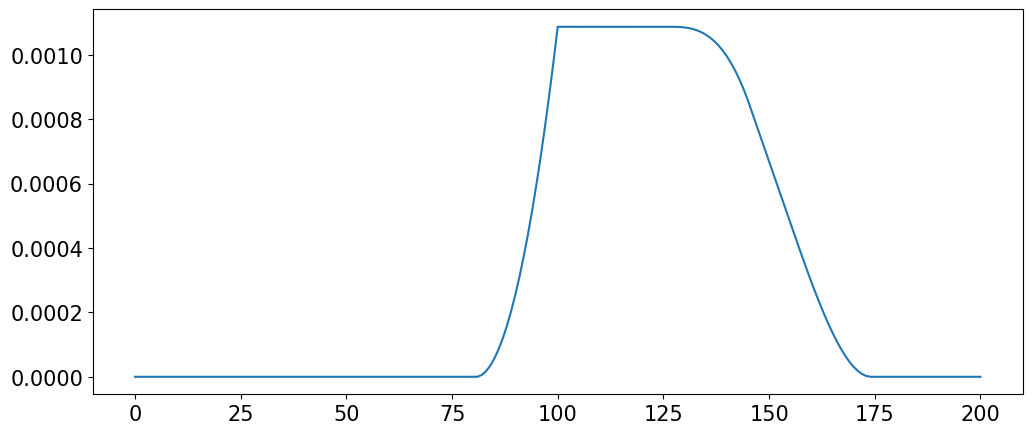

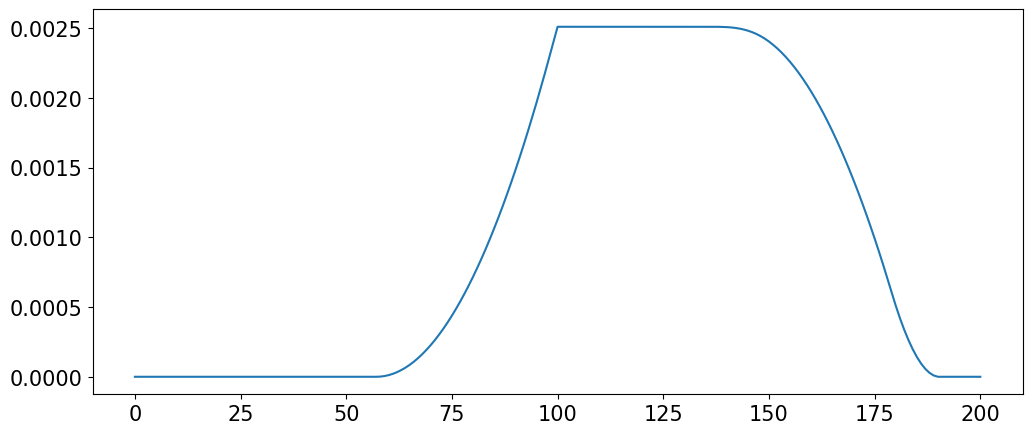

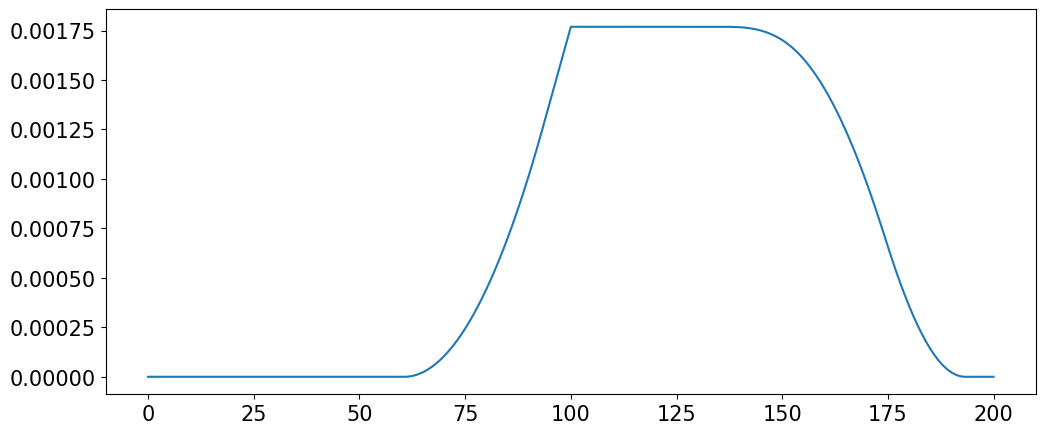

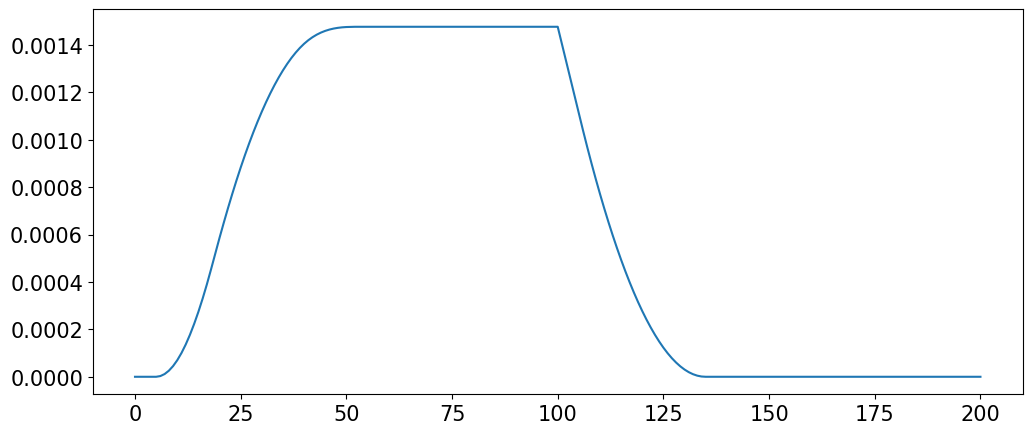

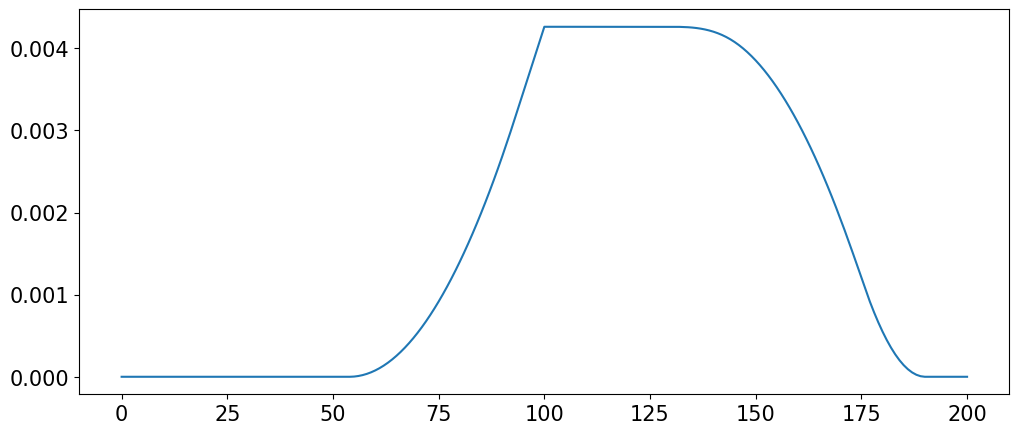

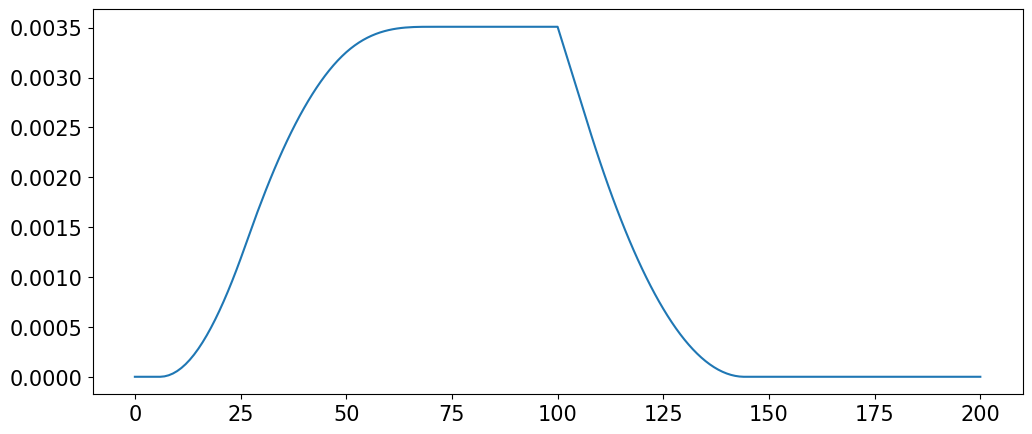

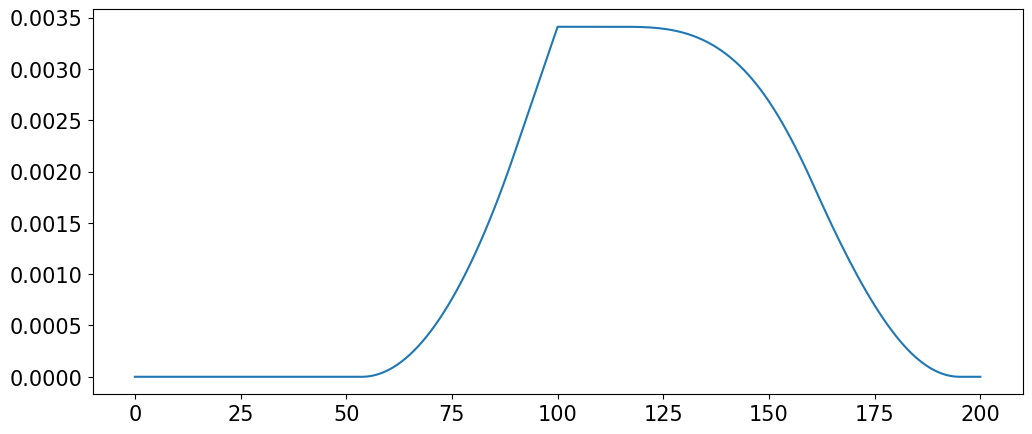

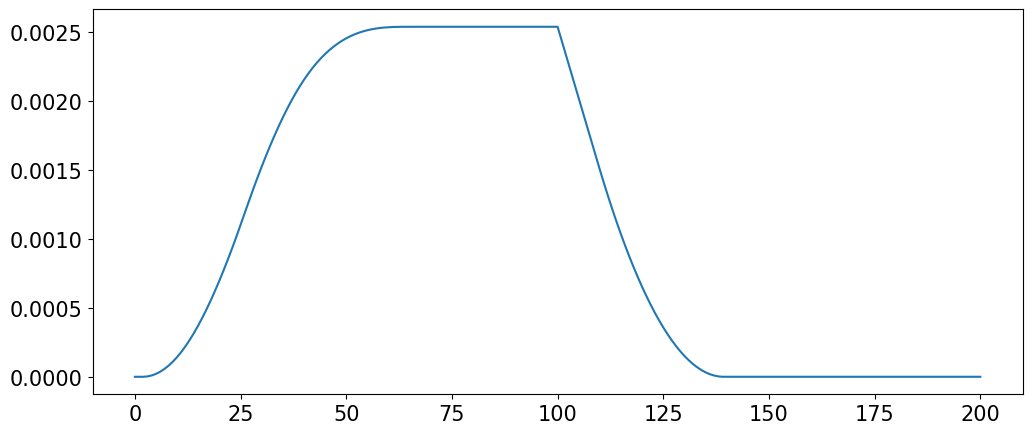

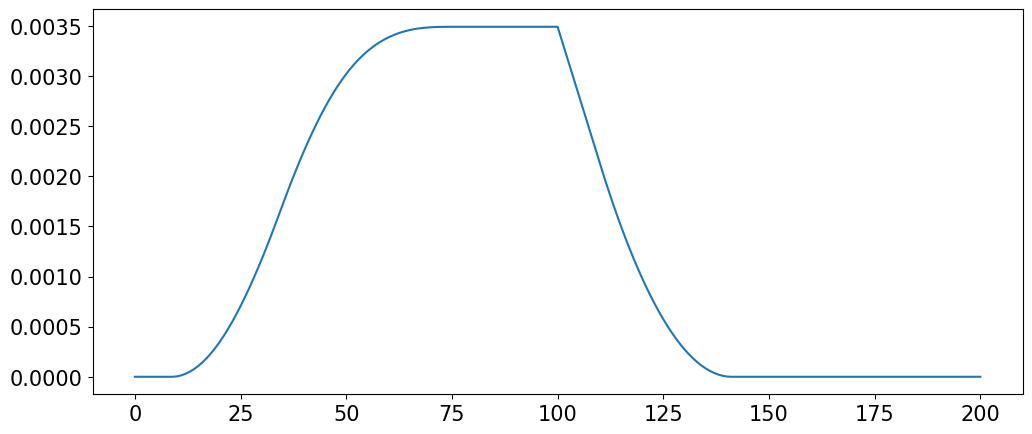

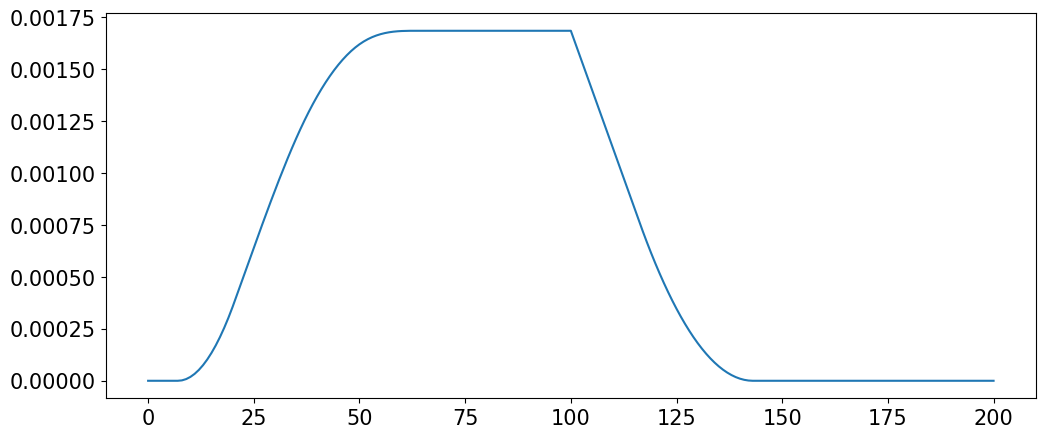

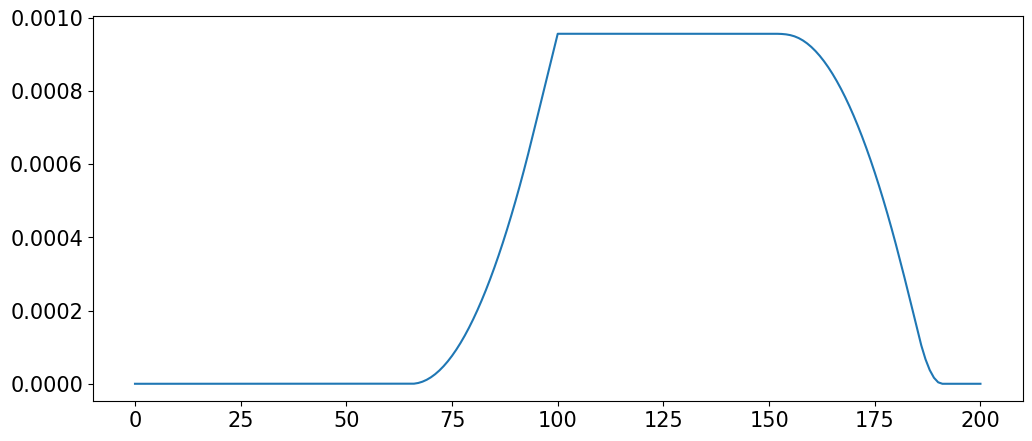

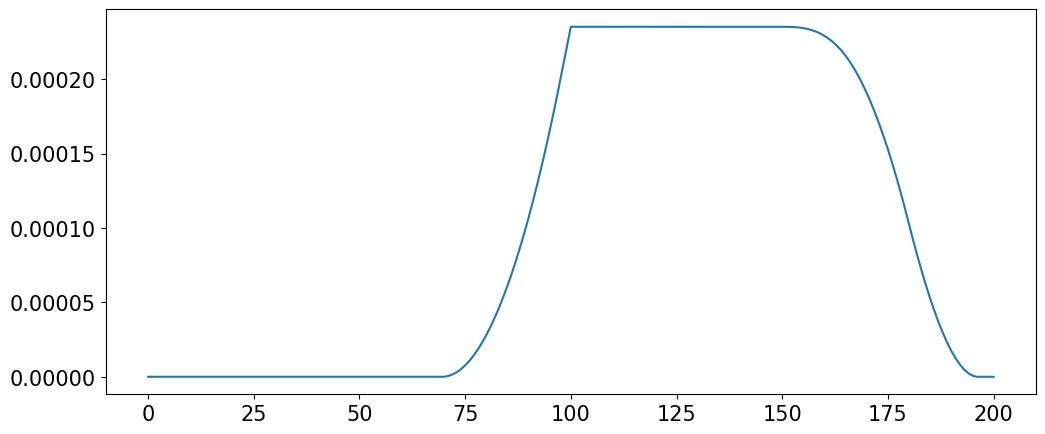

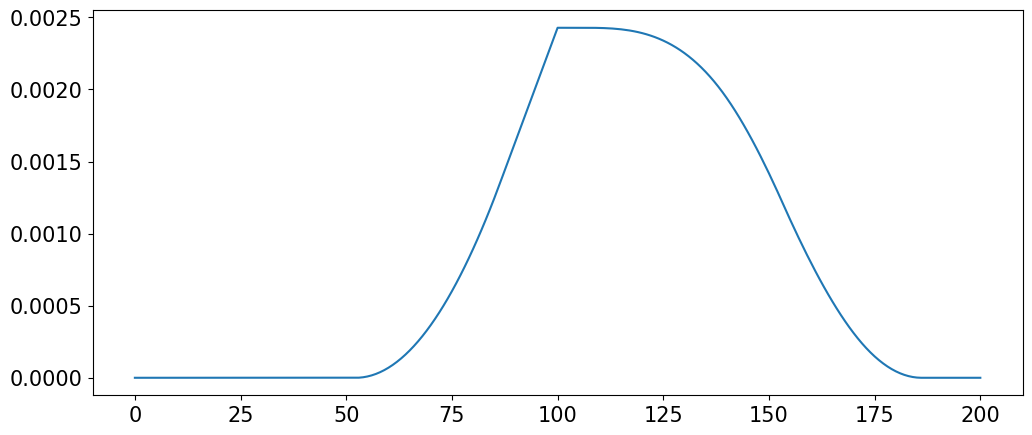

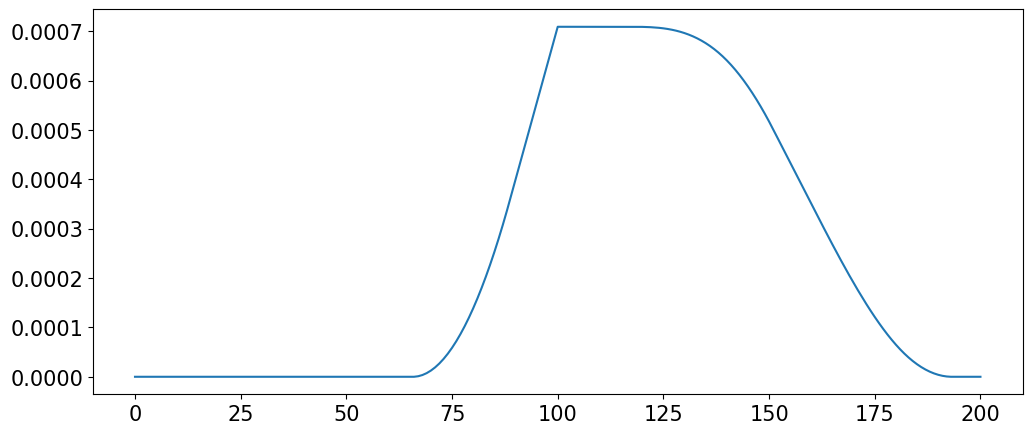

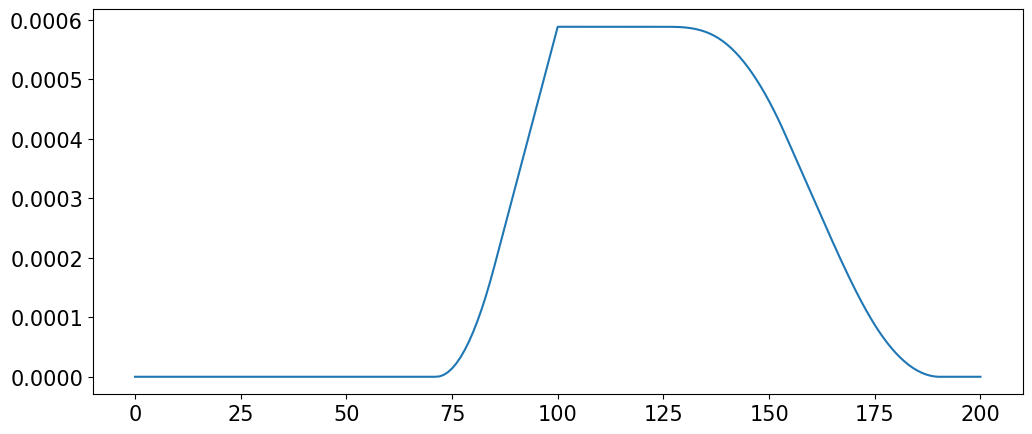

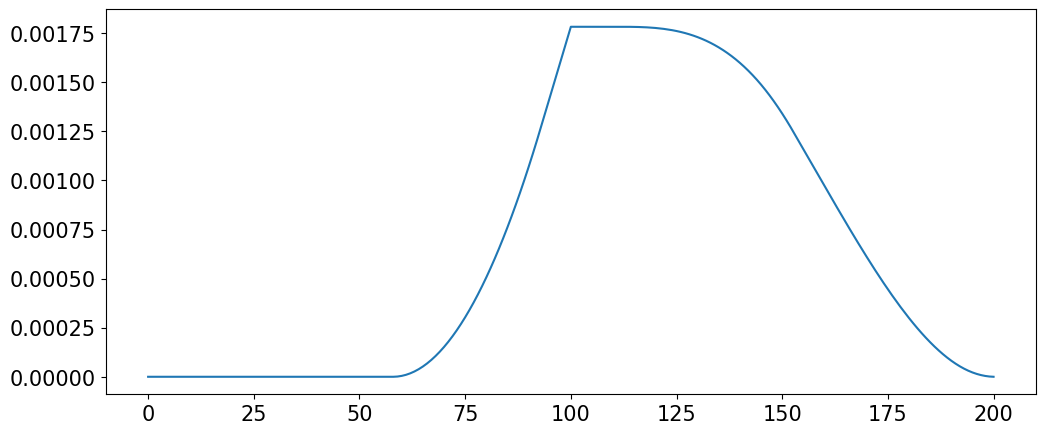

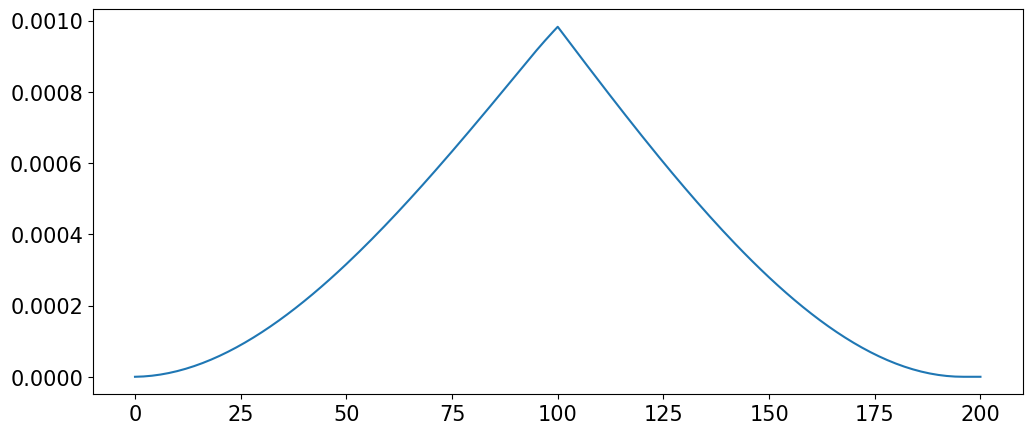

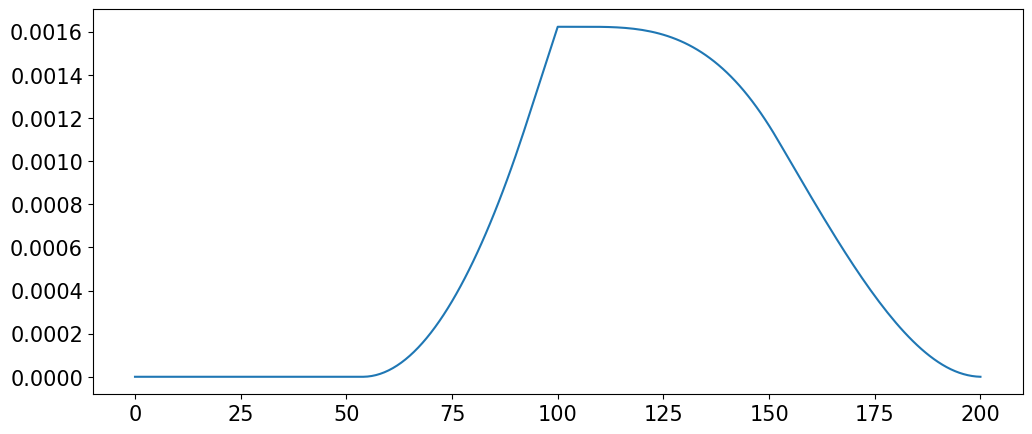

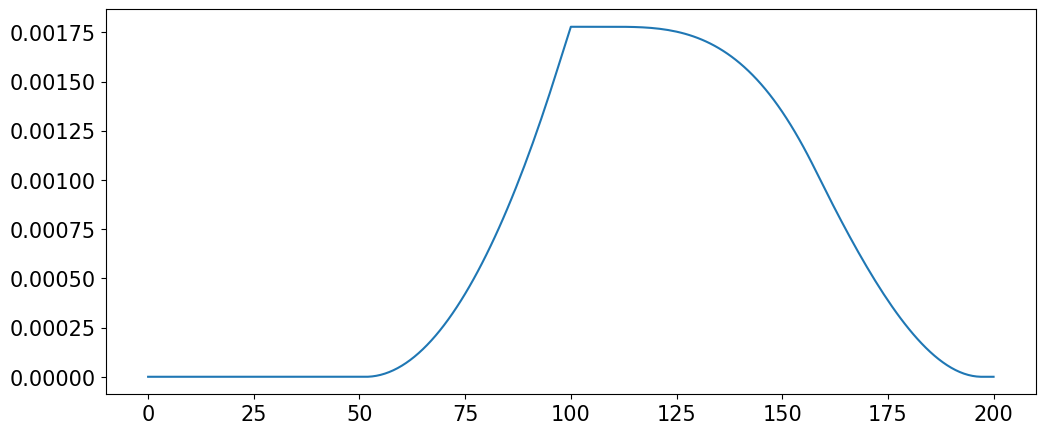

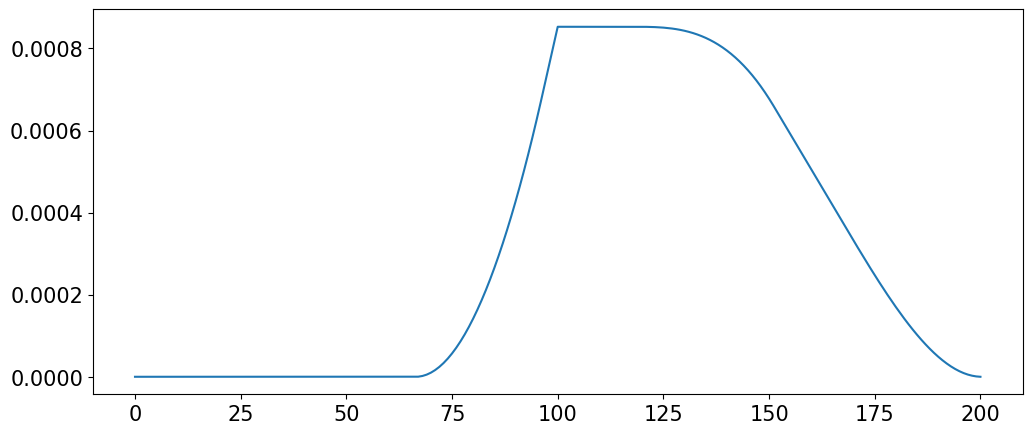

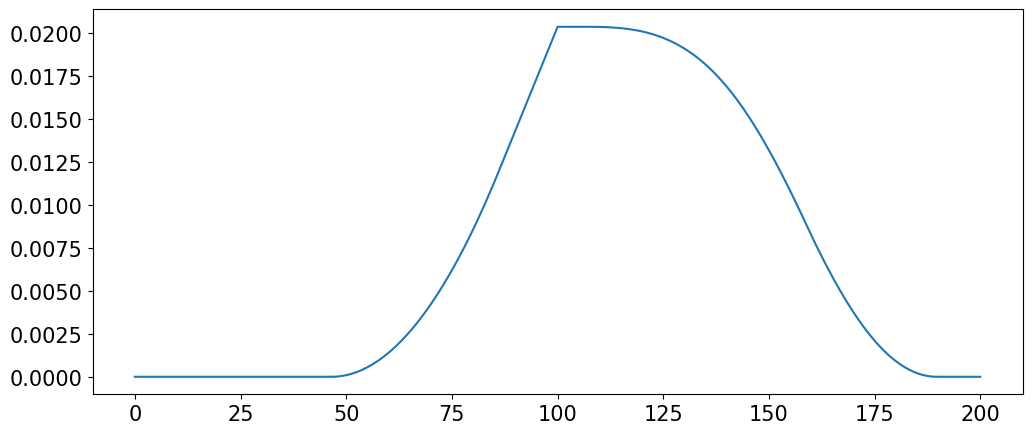

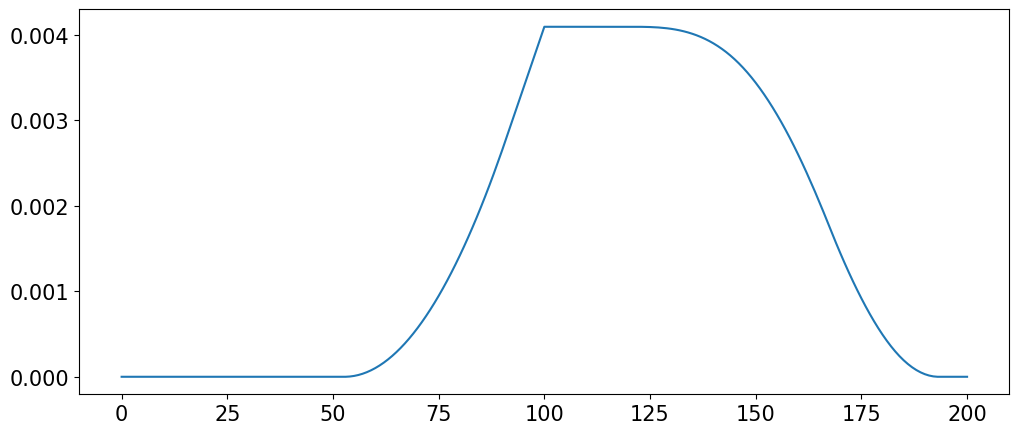

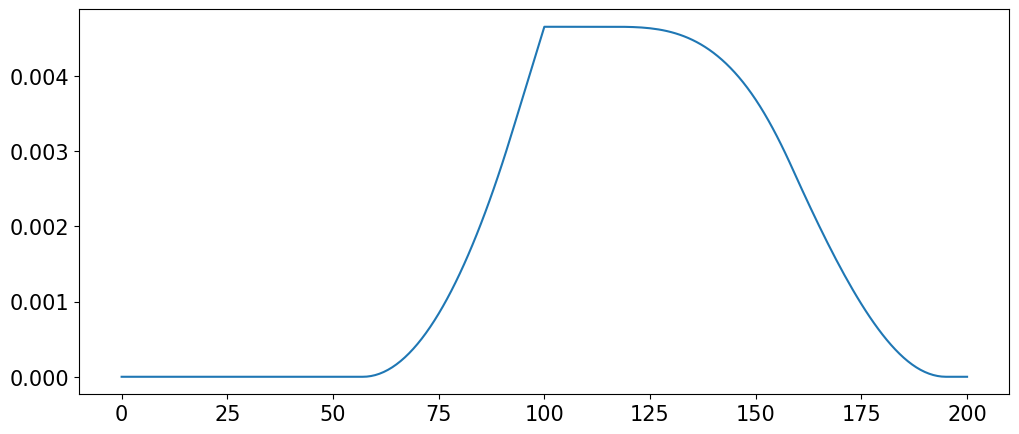

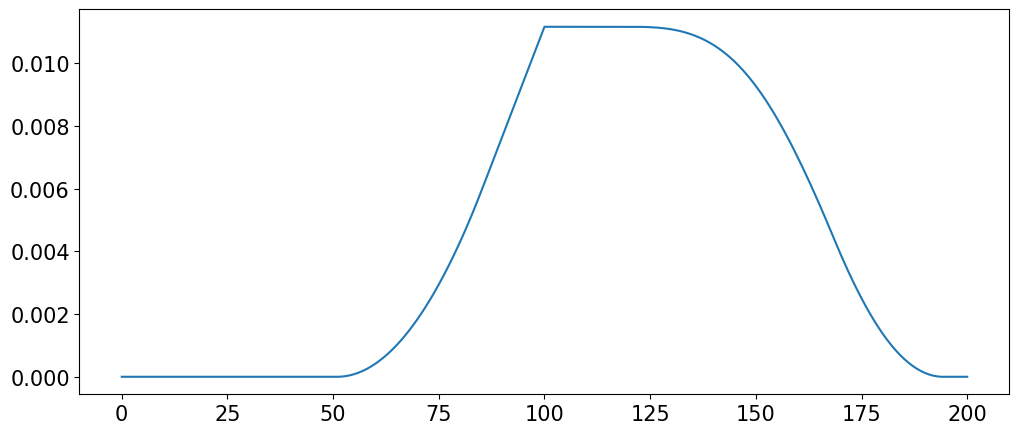

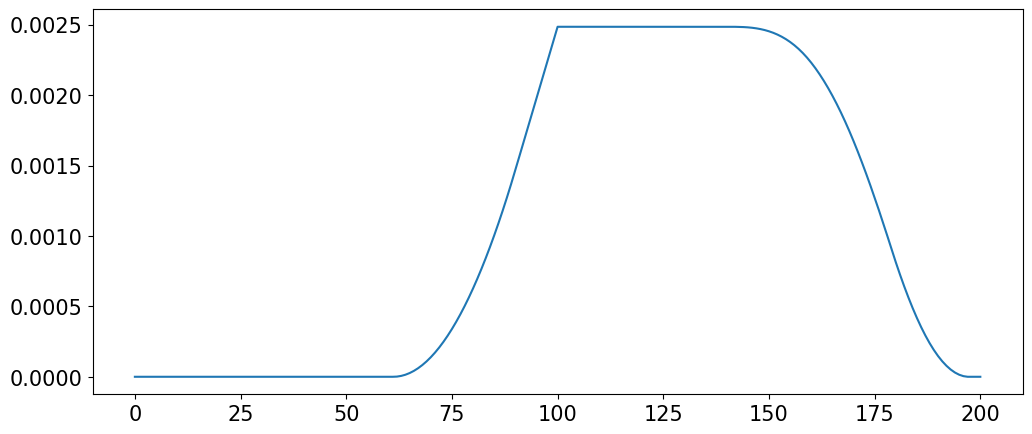

In [33]:
## correlation with fits from before

plot_fits = False

fit_qubit_couplers = product(fit_readout_qubits, fit_fixed_qubits_and_couplers, fit_sweep_qubits_and_couplers)

for qubit_coupler_label in fit_qubit_couplers:
    
#     print(qubit_coupler_label)
#     print(qubit_coupler_to_fit[qubit_coupler_label])
    
    if not qubit_coupler_label in qubit_coupler_to_fit:
        continue
        
    if plot_fits:
        for file_label, popts in qubit_coupler_to_fit[qubit_coupler_label].items():

            fit_voltages = np.linspace(-4, 4, 101)

            for i in range(len(popts)):
                popt = popts[i]
                print(popt)
                if len(popt) > 0:
                    plt.plot(fit_voltages, three_lines(fit_voltages, *popt), label=f'segment {i+1}')

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.show()

    
    for file_label, popts in qubit_coupler_to_fit[qubit_coupler_label].items():
        
        fit_voltages = np.linspace(-4, 4, 101)
        
        if len(popts) == 3:
        
            segment_1 = three_lines(fit_voltages, *popts[0])
            segment_2 = three_lines(fit_voltages, *popts[1])
            
            segment_1_offset = segment_1 - np.min(segment_1)
            segment_2_offset = segment_2 - np.min(segment_2)
            
            correlation = np.correlate(segment_1_offset, segment_2_offset, mode='full')
            
            plt.plot(correlation)
            plt.show()
        

### 2.3 Determine gap width from fit
Voltage difference between sloped lines

In [103]:
# store as (min, max)

qubit_coupler_to_differences = {}

In [107]:
## find gap from difference between fit lines

plot_fits = False

fit_readout_qubits = ['Q2', 'Q3', 'Q4']
fit_qubit_couplers = product(fit_readout_qubits, fit_fixed_qubits_and_couplers, fit_sweep_qubits_and_couplers)


for qubit_coupler_label in fit_qubit_couplers:
    
    print(qubit_coupler_label)
#     print(qubit_coupler_to_fit[qubit_coupler_label])
    
    if not qubit_coupler_label in qubit_coupler_to_fit:
        continue
        
    if not qubit_coupler_label in qubit_coupler_to_differences:
        qubit_coupler_to_differences[qubit_coupler_label] = {}

    
    for file_label, popts in qubit_coupler_to_fit[qubit_coupler_label].items():
        
        print(file_label)
        
#         qubit_coupler_to_differences[qubit_coupler_label][file_label] = []
            
        
        
        fit_voltages = np.linspace(-4, 4, 101)
        
        if len(popts) in [2, 3]:
            # 2 or 3 passes
            
            inverse_line_functions = []
            
            min_freqs = []
            max_freqs = []
            
            for i in range(len(popts)):
#             for i in range(2):
                popt = popts[i]
                
                # frequencies at voltage bounds
                frequency_1 = three_lines(popt[0], *popt)
                frequency_2 = three_lines(popt[1], *popt)
                
                max_freq = max(frequency_1, frequency_2)
                min_freq = min(frequency_1, frequency_2)
                
                
                
                # need function to create new scope for parameters in lambda function
                def create_inverse_line_function(x_0, x_1, b, c):
                    # b*(x - x0) + c
                    return lambda f: (f-c)/b + x_0
                
                def create_averaged_inverse_line_function(x_0_1, x_1_1, b_1, c_1, x_0_2, x_1_2, b_2, c_2):
                    return lambda f: ((f-c_1)/b_1 + x_0_1 + (f-c_2)/b_2 + x_0_2)/2
                
                inverse_line = create_inverse_line_function(*popt)
                
                if i < 2:
                    inverse_line_functions.append(inverse_line)
                    min_freqs.append(min_freq)
                    max_freqs.append(max_freq)
                elif i == 2:
                    # if there is a third segment with a line fit, average it with the first segment
                    inverse_line_functions[0] = create_averaged_inverse_line_function(*popts[0], *popt)
                    # restrict the bounds more
                    min_freqs[0] = max(min_freqs[0], min_freq)
                    max_freqs[0] = min(max_freqs[0], max_freq)
            
                
                if plot_fits:
                    inverse_fit_frequencies = np.linspace(min_freq, max_freq, 101)
                    plt.plot(inverse_fit_frequencies, inverse_line(inverse_fit_frequencies), label=f'segment {i+1} inverse line')
                
            if plot_fits:
                plt.plot(qubit_coupler_to_frequencies[qubit_coupler_label][file_label], qubit_coupler_to_voltages[qubit_coupler_label][file_label],
                        marker='o', linestyle='', label='data')

                plt.xlabel('Frequency (GHz)')
                plt.ylabel('Voltage (V)')
                plt.title(f'Hysteresis fit voltage vs frequency, sweep {qubit_coupler_label[2]}, fix {qubit_coupler_label[1]}, readout {qubit_coupler_label[0]}')
                plt.legend()
                plt.show()
            
            difference_function = lambda f: inverse_line_functions[0](f) - inverse_line_functions[1](f)
            
            difference_fit_frequencies = np.linspace(max(min_freqs), min(max_freqs), 101)
            difference_fit_voltages = difference_function(difference_fit_frequencies)
            
            qubit_coupler_to_differences[qubit_coupler_label][file_label] = (np.min(difference_fit_voltages), np.max(difference_fit_voltages))
            
            if plot_fits:
                plt.plot(difference_fit_frequencies, difference_fit_voltages)

                plt.title(f'Difference between two sides, sweep {qubit_coupler_label[2]}, fix {qubit_coupler_label[1]}, readout {qubit_coupler_label[0]}')

                plt.xlabel('Frequency (GHz)')
                plt.ylabel('Voltage (V)')
                plt.show()
        else:
#             print(len(popts))
            pass

('Q2', 'Q2', 'Q2')
default
('Q2', 'Q2', 'Q3')
('Q2', 'Q2', 'Q4')
('Q2', 'Q2', 'C12')
('Q2', 'Q2', 'C13')
('Q2', 'Q2', 'C23')
('Q2', 'Q2', 'C24')
('Q2', 'Q2', 'C34')
('Q2', 'Q3', 'Q2')
('Q2', 'Q3', 'Q3')
('Q2', 'Q3', 'Q4')
('Q2', 'Q3', 'C12')
('Q2', 'Q3', 'C13')
('Q2', 'Q3', 'C23')
('Q2', 'Q3', 'C24')
('Q2', 'Q3', 'C34')
('Q2', 'Q4', 'Q2')
('Q2', 'Q4', 'Q3')
('Q2', 'Q4', 'Q4')
('Q2', 'Q4', 'C12')
('Q2', 'Q4', 'C13')
('Q2', 'Q4', 'C23')
('Q2', 'Q4', 'C24')
('Q2', 'Q4', 'C34')
('Q2', 'C12', 'Q2')
('Q2', 'C12', 'Q3')
('Q2', 'C12', 'Q4')
('Q2', 'C12', 'C12')
default
slow
C12 +1 flux
('Q2', 'C12', 'C13')
default
('Q2', 'C12', 'C23')
default
reverse
('Q2', 'C12', 'C24')
default
reverse
C12 +1 flux
+4 --> -2.5 C12 +1 flux
+4 --> -4 C12 +1 flux
+4 --> -2 C12 +1 flux
('Q2', 'C12', 'C34')
default
('Q2', 'C13', 'Q2')
('Q2', 'C13', 'Q3')
('Q2', 'C13', 'Q4')
('Q2', 'C13', 'C12')
('Q2', 'C13', 'C13')
('Q2', 'C13', 'C23')
('Q2', 'C13', 'C24')
('Q2', 'C13', 'C34')
('Q2', 'C23', 'Q2')
('Q2', 'C23', 'Q3'

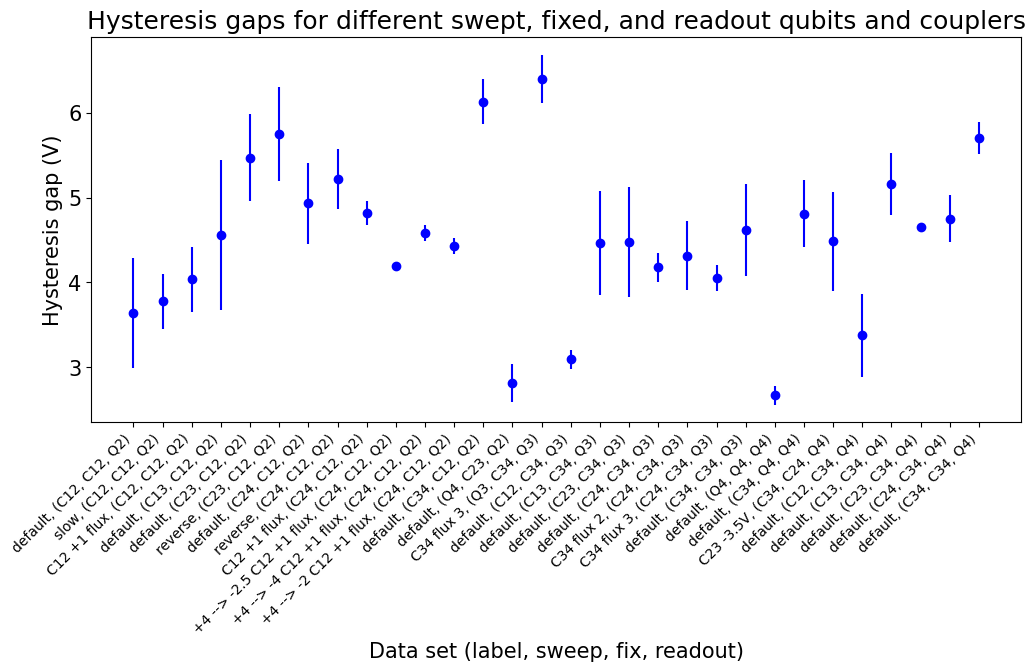

In [135]:
### plot differences

counter = 0
labels = []

for qubit_coupler_label in qubit_coupler_to_differences:
    for file_label, differences in qubit_coupler_to_differences[qubit_coupler_label].items():
        
        average_value = np.mean(differences)
        
        
        color = 'blue'
        
        if qubit_coupler_label in qubit_coupler_to_bad_fits and file_label in qubit_coupler_to_bad_fits[qubit_coupler_label]:
            color='red'
            continue
            
        labels.append(f'{file_label}, ({qubit_coupler_label[2]}, {qubit_coupler_label[1]}, {qubit_coupler_label[0]})')
        
        plt.errorbar(counter, abs(average_value), yerr=abs(differences[1] - average_value), marker='o', linestyle='', color=color)
        
        counter += 1

plt.xlabel('Data set (label, sweep, fix, readout)')

plt.xticks(range(counter), labels, rotation=45, ha='right', fontsize=10)
plt.ylabel('Hysteresis gap (V)')

plt.title('Hysteresis gaps for different swept, fixed, and readout qubits and couplers')

plt.show()

In [114]:
def plot_hysteresis_gap(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers, skip_labels=[], include_labels=None):
    
    qubit_coupler_labels = product(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers)
    
    counter = 0
    x_labels = []
    
    for qubit_coupler_label in qubit_coupler_labels:
        
#         print(qubit_coupler_label)
        
        if not qubit_coupler_label in qubit_coupler_to_differences:
            continue
        
        for file_label, differences in qubit_coupler_to_differences[qubit_coupler_label].items():
            
#             print(file_label)
            
            # prioritize include labels over skip labels
            if not include_labels is None:
                if not file_label in include_labels:
                    continue
            else:
                if file_label in skip_labels:
                    continue
                    
            average_value = np.mean(differences)            
            
            color = 'blue'
        
            if qubit_coupler_label in qubit_coupler_to_bad_fits and file_label in qubit_coupler_to_bad_fits[qubit_coupler_label]:
                continue

            x_labels.append(f'{file_label}, ({qubit_coupler_label[2]}, {qubit_coupler_label[1]}, {qubit_coupler_label[0]})')
        
#             print(x_labels[-1])
        
            plt.errorbar(counter, abs(average_value), yerr=abs(differences[1] - average_value), marker='o', linestyle='', color=color)

            counter += 1
            
    plt.xlabel('Data set (label, sweep, fix, readout)')

    plt.xticks(range(counter), x_labels, rotation=45, ha='right', fontsize=10)
    plt.ylabel('Hysteresis gap (V)')

    plt.title('Hysteresis gaps for different swept, fixed, and readout qubits and couplers')

    plt.show()
    


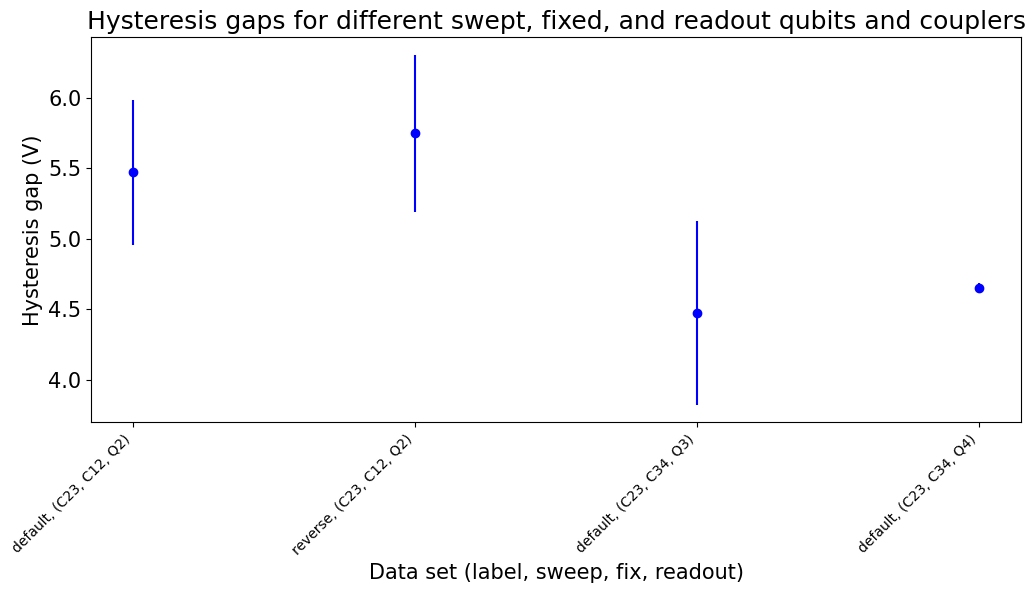

In [101]:
readout_qubits = ['Q2', 'Q4']
readout_qubits = ['Q4']
readout_qubits = ['Q2']
readout_qubits = ['Q2', 'Q3', 'Q4']

fixed_qubits_and_couplers = ['C12', 'C34', 'Q2', 'C23']
fixed_qubits_and_couplers = ['C12']
fixed_qubits_and_couplers = ['C34']
fixed_qubits_and_couplers = ['C24']
fixed_qubits_and_couplers = all_qubits_and_couplers

sweep_qubits_and_couplers = ['C12', 'C13', 'C23', 'C24', 'C34', 'Q2', 'Q3', 'Q4']
sweep_qubits_and_couplers = ['C24']
sweep_qubits_and_couplers = ['C23']
# sweep_qubits_and_couplers = ['C12']
# sweep_qubits_and_couplers = ['C13']
# sweep_qubits_and_couplers = ['C34']
# sweep_qubits_and_couplers = all_qubits_and_couplers

skip_labels = []
# skip_labels = ['default', 'reverse', 'C12 +1 flux', '+4 --> -2.5 C12 +1 flux', '+4 --> -4 C12 +1 flux', '+4 --> -2 C12 +1 flux']

# include_labels = ['default', 'C12 +1 flux']
include_labels = None

plot_hysteresis_gap(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers, skip_labels=skip_labels, include_labels=include_labels)


In [72]:
print(qubit_coupler_to_differences[('Q2', 'C34', 'C12')])

{}


### 2.4 Hysteresis shift from fit
Frequency difference bewteen top and bottom flat lines

In [105]:
qubit_coupler_to_shift = {}

In [110]:
## find gap from difference between fit lines

plot_fits = False

fit_readout_qubits = ['Q2', 'Q3', 'Q4']
fit_qubit_couplers = product(fit_readout_qubits, fit_fixed_qubits_and_couplers, fit_sweep_qubits_and_couplers)


for qubit_coupler_label in fit_qubit_couplers:
    
    print(qubit_coupler_label)
#     print(qubit_coupler_to_fit[qubit_coupler_label])
    
    if not qubit_coupler_label in qubit_coupler_to_fit:
        continue
        
    if not qubit_coupler_label in qubit_coupler_to_shift:
        qubit_coupler_to_shift[qubit_coupler_label] = {}

    
    for file_label, popts in qubit_coupler_to_fit[qubit_coupler_label].items():
        
        print(file_label)
        
#         qubit_coupler_to_differences[qubit_coupler_label][file_label] = []
            
        
        
        fit_voltages = np.linspace(-4, 4, 101)
        
            
        if len(popts) == 2:
            # 2 passes
            difference = np.abs(three_lines(fit_voltages, *popts[0]) - three_lines(fit_voltages, *popts[1]))
            max_difference = np.max(difference)
            qubit_coupler_to_shift[qubit_coupler_label][file_label] = max_difference
        elif len(popts) == 3:
            # 3 passes
            # average first and third segmants
            difference = np.abs(three_lines(fit_voltages, *popts[0])/2 + three_lines(fit_voltages, *popts[2])/2 - three_lines(fit_voltages, *popts[1]))
            max_difference = np.max(difference)
            qubit_coupler_to_shift[qubit_coupler_label][file_label] = max_difference
        else:
#             print(len(popts))
            pass

('Q2', 'Q2', 'Q2')
default
('Q2', 'Q2', 'Q3')
('Q2', 'Q2', 'Q4')
('Q2', 'Q2', 'C12')
('Q2', 'Q2', 'C13')
('Q2', 'Q2', 'C23')
('Q2', 'Q2', 'C24')
('Q2', 'Q2', 'C34')
('Q2', 'Q3', 'Q2')
('Q2', 'Q3', 'Q3')
('Q2', 'Q3', 'Q4')
('Q2', 'Q3', 'C12')
('Q2', 'Q3', 'C13')
('Q2', 'Q3', 'C23')
('Q2', 'Q3', 'C24')
('Q2', 'Q3', 'C34')
('Q2', 'Q4', 'Q2')
('Q2', 'Q4', 'Q3')
('Q2', 'Q4', 'Q4')
('Q2', 'Q4', 'C12')
('Q2', 'Q4', 'C13')
('Q2', 'Q4', 'C23')
('Q2', 'Q4', 'C24')
('Q2', 'Q4', 'C34')
('Q2', 'C12', 'Q2')
('Q2', 'C12', 'Q3')
('Q2', 'C12', 'Q4')
('Q2', 'C12', 'C12')
default
slow
C12 +1 flux
('Q2', 'C12', 'C13')
default
('Q2', 'C12', 'C23')
default
reverse
('Q2', 'C12', 'C24')
default
reverse
C12 +1 flux
+4 --> -2.5 C12 +1 flux
+4 --> -4 C12 +1 flux
+4 --> -2 C12 +1 flux
('Q2', 'C12', 'C34')
default
('Q2', 'C13', 'Q2')
('Q2', 'C13', 'Q3')
('Q2', 'C13', 'Q4')
('Q2', 'C13', 'C12')
('Q2', 'C13', 'C13')
('Q2', 'C13', 'C23')
('Q2', 'C13', 'C24')
('Q2', 'C13', 'C34')
('Q2', 'C23', 'Q2')
('Q2', 'C23', 'Q3'

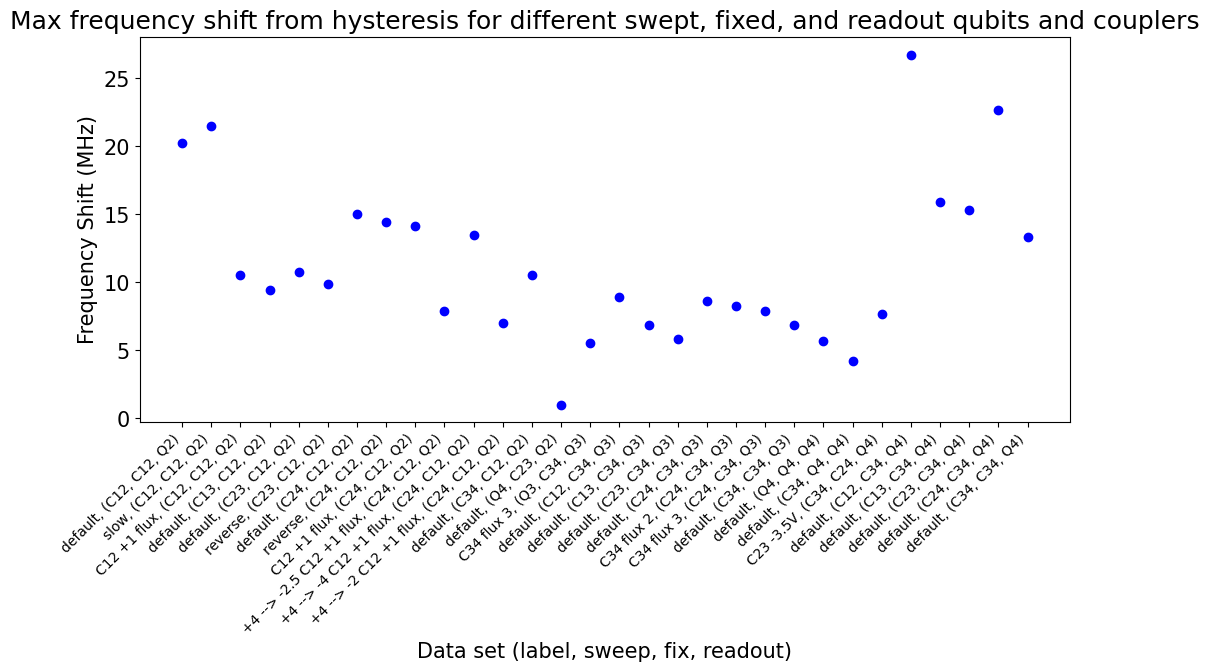

In [136]:
### plot shifts

counter = 0
labels = []

for qubit_coupler_label in qubit_coupler_to_shift:
    for file_label, shift in qubit_coupler_to_shift[qubit_coupler_label].items():
        
        color = 'blue'
        
        if qubit_coupler_label in qubit_coupler_to_bad_fits and file_label in qubit_coupler_to_bad_fits[qubit_coupler_label]:
            color='red'
            continue
            
        labels.append(f'{file_label}, ({qubit_coupler_label[2]}, {qubit_coupler_label[1]}, {qubit_coupler_label[0]})')
        
        plt.plot(counter, shift*1e3, marker='o', linestyle='', color=color)
        
        counter += 1

plt.xlabel('Data set (label, sweep, fix, readout)')

plt.xticks(range(counter), labels, rotation=45, ha='right', fontsize=10)
plt.ylabel('Frequency Shift (MHz)')

plt.title('Max frequency shift from hysteresis for different swept, fixed, and readout qubits and couplers')

plt.show()

In [118]:
def plot_hysteresis_shift(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers, skip_labels=[], include_labels=None):
    
    qubit_coupler_labels = product(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers)
    
    counter = 0
    x_labels = []
    
    for qubit_coupler_label in qubit_coupler_labels:
        
#         print(qubit_coupler_label)
        
        if not qubit_coupler_label in qubit_coupler_to_shift:
            continue
        
        for file_label, shift in qubit_coupler_to_shift[qubit_coupler_label].items():
            
            # prioritize include labels over skip labels
            if not include_labels is None:
                if not file_label in include_labels:
                    continue
            else:
                if file_label in skip_labels:
                    continue
                    
            color = 'blue'
        
            if qubit_coupler_label in qubit_coupler_to_bad_fits and file_label in qubit_coupler_to_bad_fits[qubit_coupler_label]:
                color='red'
                continue

            x_labels.append(f'{file_label}, ({qubit_coupler_label[2]}, {qubit_coupler_label[1]}, {qubit_coupler_label[0]})')

            plt.plot(counter, shift*1e3, marker='o', linestyle='', color=color)

            counter += 1
            
    plt.xlabel('Data set (label, sweep, fix, readout)')

    plt.xticks(range(counter), x_labels, rotation=45, ha='right', fontsize=10)
    plt.ylabel('Hysteresis gap (V)')

    plt.title('Hysteresis gaps for different swept, fixed, and readout qubits and couplers')

    plt.show()
    


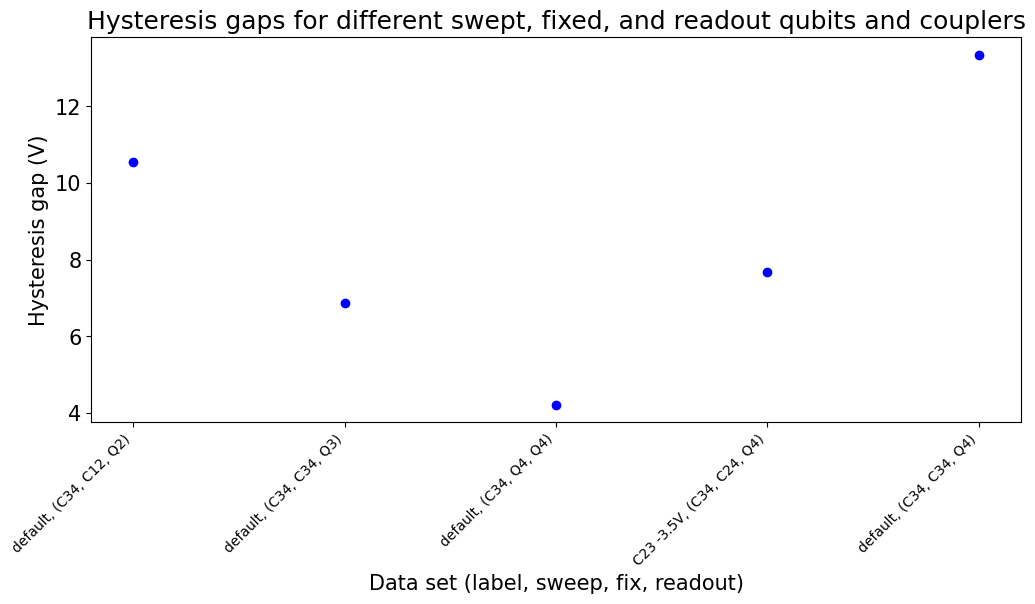

In [125]:
readout_qubits = ['Q2', 'Q4']
readout_qubits = ['Q4']
readout_qubits = ['Q2']
readout_qubits = ['Q3']
readout_qubits = ['Q2', 'Q3', 'Q4']

fixed_qubits_and_couplers = ['C12', 'C34', 'Q2', 'C23']
# fixed_qubits_and_couplers = ['C12']
# fixed_qubits_and_couplers = ['C34']
# fixed_qubits_and_couplers = ['C24']
fixed_qubits_and_couplers = all_qubits_and_couplers

sweep_qubits_and_couplers = ['C12', 'C13', 'C23', 'C24', 'C34', 'Q2', 'Q3', 'Q4']
sweep_qubits_and_couplers = ['C24']
sweep_qubits_and_couplers = ['C23']
# sweep_qubits_and_couplers = ['C12']
# sweep_qubits_and_couplers = ['C13']
sweep_qubits_and_couplers = ['C34']
# sweep_qubits_and_couplers = all_qubits_and_couplers

skip_labels = []
# skip_labels = ['default', 'reverse', 'C12 +1 flux', '+4 --> -2.5 C12 +1 flux', '+4 --> -4 C12 +1 flux', '+4 --> -2 C12 +1 flux']

# include_labels = ['default', 'C12 +1 flux']
include_labels = None

plot_hysteresis_shift(readout_qubits, fixed_qubits_and_couplers, sweep_qubits_and_couplers, skip_labels=skip_labels, include_labels=include_labels)
